# Cobinding PiPeline: pre processing & analysis

In [201]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats

import numpy as np

from JKBio.epigenetics import ChIP_helper as chiphelper
from JKBio import Helper as helper
from JKBio import GCPFunction as gcp
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
project="Cobinding_ChIP"
version="v3"

## processing using Nextflow

In [78]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/paired_end/*MV411* # all other cell lines don't have the right INPUT
fastq

['gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp324-MV411-MEF2D-r1_R1.fastq.gz',
 'gs://aml

In [94]:
from gsheets import Sheets
# Here you might not need this line, otherwise you need to generate your json files from 
# https://pygsheets.readthedocs.io/en/stable/authorization.html
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [80]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in helper.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    if row['matching input name'].values[0] is not None:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_paired_end_design.csv',index=False)

In [97]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/*.gz
fastq

['gs://amlproject/Chip/fastqs/db28-MV411-H3K18-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db29-MV411-AFF4-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db30-MV411-CDK9-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db31-MV411-PSER2-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db32-MV411-INPUT-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db33-MV411-INPUT-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db34-MV411-CEBPB-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db35-MV411-INPUT-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db36-MV411-INPUT-r4.fastq.gz',
 'gs://amlproject/Chip/fastqs/db37-MV411-WDR5_429A-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db38-MV411-WDR5_429A-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db39-MV411-WDR5_429A-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db40-MV411-WDR5_D9E1-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db41-MV411-WDR5_D9E1-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db42-MV411-WDR5_D9E1-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db43-MV411-IGG-r1.fastq.gz',
 'gs

In [98]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] in ["IRF2BP2", "H3K27ac", "H3K36me3", "H3K27me3", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "H3K18", "BRD4"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_np.csv',index=False)

In [93]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] not in ['INPUT',"IGG","IRF2BP2", "H3K27ac", "CEBPA", "H3K36me3", "PU1", "H3K27me3", "SMC1", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "CEBPB", "H3K18", "BRD4", "WDR5"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_bp.csv',index=False)

## Pipeline

![](images/gcpjup.png)


- Raw read QC (FastQC)
- Adapter trimming (Trim Galore!)
- Alignment (BWA)
- Mark duplicates (picard)
- Merge alignments from multiple libraries of the same sample (picard)
- Re-mark duplicates (picard)
- Filtering to remove: blacklisted regions, duplicates, primary alignments,unmapped,multiple locations, containing >  4 mismatches, insert size > 2kb, map to different chromosomes 
- Alignment-level QC and estimation of library complexity (picard, Preseq)
- Create normalised bigWig files scaled to 1 million mapped reads (BEDTools, bedGraphToBigWig)
- Generate gene-body meta-profile from bigWig files (deepTools)
- Calculate genome-wide IP enrichment relative to control (deepTools)
- Calculate strand cross-correlation peak and ChIP-seq quality measures including NSC and RSC (phantompeakqualtools)
- Call broad/narrow peaks (MACS2)
- Annotate peaks relative to gene features (HOMER)
- Create consensus peakset across all samples and create tabular file to aid in the filtering of the data (BEDTools)
- Count reads in consensus peaks (featureCounts)

![](images/nfcore.png)


## about
0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`
3. you will export the credentials to your google account (see google cloud oauth) `export GOOGLE_APPLICATION_CREDENTIALS=aml-chipseq-rnaseq-9dcbe47182cf.json`
4. look more about the chipseq pipeline here: https://nf-co.re/chipseq
5. now you can run the code as below (to run it locally, use `-profile docker`)
6. to run it on google cloud make a conf file with your google paymnt project id: `echo "google.project = 'YOUR_GOOGLE_PROJECT_ID'" >> my.config` and run the pipeline using: `-profile jkcloud --custom_local_config my.conf`
7. to run it elsewhere, look at nf-core's documentation

In [ ]:
-profile #my profile for the cloud (to edit for your account) jkcloud
-w #where the withinput will be stored
--outdir #specify aa bucket+folderr where the results will be
--tracedir #you need to specify a local place for that
--custom_local_config custom_local.config #yoour custtom config

In [66]:
#process chips 
! ../../nextflow run jkobject/chipseq --paired_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_paired_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingp --outdir gs://workamlproject/cobindingpres --tracedir ../nextflow/cobindingp/ --narrow_peak

.nextflow/history.lock (Permission denied)


In [ ]:
#calling narrow peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindings --outdir gs://workamlproject/cobindingsres --tracedir ../nextflow/cobindings/ --narrow_peak

In [ ]:
#calling broad peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_broad_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingsb --outdir gs://workamlproject/cobindingsbres --tracedir ../nextflow/cobindingsb/

## Gathering data

we are using a folder outside our repository as there is too many huge files.

In [105]:
! gsutil -m cp -r gs://workamlproject/cobindingpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_pe_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [106]:
! gsutil -m cp -r gs://workamlproject/cobindingsbpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_bp.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/broadPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db28-MV411-H3K18_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db33-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db35-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db43-MV411-IGG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db32-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db45-MV411-IGG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/db34-MV411-CEBPB_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp5-D9-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp50-OCIAML2-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp53-HL60-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp56-Kasumi1-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp575-MV411-IRF2BP2_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp577-MV411-SMC1_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/mp58-KG1-H3K27ac_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workam

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db52-MV411-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db53-MV411-H3K9ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/db54-MV411-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp100-U937-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp101-NOMO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp102-UT7-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp315-MONOMAC6-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp316-SKNO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp326-DFAM71927V3-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp35-D9-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp33-OCIAML2-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp351-D0-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibra

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp77-HL60-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp776-P31FUJ-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp777-MONOMAC1-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp778-MONOMAC1-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp8-D0-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/bigwig/scale/mp88-MV411-H3K27ac_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedL

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp213-U937-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp214-UT7-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp216-SKNO1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp217-HEL-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp218-HEL-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp231-SKNO1-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp24-OCIAML2-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp718-MV411-IRF2BP2_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp72-MV411-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp728-MV411_DMSO-CEBPA_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp73-U937-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp734-MV411_DMSO-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp752-SHI1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/counts/mp754-EOL1-H3K27ac_R1_T1.txt [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db51-MV411-H3K36me2_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db52-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db53-MV411-H3K9ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db53-MV411-H3K9ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db54-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/db54-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp154-D9-PU1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp154-D9-PU1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp157-D9-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp160-D9-MED1_R1.plotFingerprint.pdf 

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp354-D9-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp355-M6-H3K27ac_R1.plotFingerpri

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp591-MONOMAC1-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp592-MONOMAC1-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp593-HEL9217-H3K27ac_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp593-HEL9

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp88-MV411-H3K27ac_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp88-MV411-H3K27ac_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp89-MV411-H3K36me3_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp90-U937-H3K27a

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db44-MV411-IGG_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://w

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db53-MV411-H3K9ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db54-MV411-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/db54-MV411-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp120-HL60-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp120-HL60-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp121-UCSDAML1-INPUT_R1.plotHeatmap.pdf [Content-Type=application/oct

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp187-UT7-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp203-NB4-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp204-TF1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp204-TF1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp217-HEL-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp217-HEL-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp218-HEL-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp311-MOLM13-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp312-NB4-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp351-D0-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp352-D0-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp53-HL60-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp56-Kasumi1-H3K27ac_R1.plotProfile.pdf [Content-Type=applicatio

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp67-OCIAML2-H3K27ac_R1.plotProfile.tab [Content-Type=applica

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp734-MV411_DMSO-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp752-SHI1-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=a

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp77-HL60-H3K27ac_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp77-HL60-H3K27ac_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp776-P31FUJ-H3K27ac_R1.plotHeatmap.pdf [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/deepTools/plotProfile/mp98-M6-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workaml

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.intersect.plot.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.featureCounts.tx

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp115-MV411-PU1_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp122-M6-CEBPA_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp128-M6-MED1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broa

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp188-UCSDAML1-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp193-NB4-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp193-NB4-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp216-SKNO1-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp217-HEL-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp217-HEL-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsb

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp430-MV411-IRF2BP2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp431-MV411-IRF2BP2_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpre

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp593-HEL9217-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp593-HEL9217-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp594-HEL9217-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindin

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp734-MV411_DMSO-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp734-MV411_DMSO-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/mp77-HL60-H3K27ac_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bw

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp204-TF1-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp204-TF1-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp205-OCIAML3-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp205-OCIAML3-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp206-MONOMAC6-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp206-MONOMAC6-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
C

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp56-Kasumi1-H3K27ac_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp56-Kasumi1-H3K27ac_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp575-MV411-IRF2BP2_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp577-MV411-SMC1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp575-MV411-IRF2BP2_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/macs/broadPeak/qc/mp577-MV411-SMC1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp109-M6-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp109-M6-CEBPA_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp112-MV411-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp197-SKNO1-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp197-SKNO1-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp204-TF1-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=appl

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp355-M6-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp356-M6-H3K27ac_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp356-M6-H3K27ac_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp4-D9-IGG_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp4-D9-IGG_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp41-OCIAML2-CEBPA_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp41-OCIAML2-CEBPA_R1.mLb.clN.sorted.bam.bai [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db28-MV411-H3K18_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/me

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db47-MV411-BRD4_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db48-MV411-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/db48-MV411-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp138-MV411-H3K4me3_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp14-D9-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp193-NB4-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp193-NB4-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp194-TF1-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp213-U937-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp214-UT7-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobin

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp311-MOLM13-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp312-NB4-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp352-D0-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp353-D9-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp435-MV411-MED1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp45-OCIAML2-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp631-SKNO1-PU1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp67-OCIAML2-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp67-OCIAML2-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp754-EOL1-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp755-EOL1-H3K27ac_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp755-EOL1-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobi

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp88-MV411-H3K27ac_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp89-MV411-H3K36me3_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/phantompeakqualtools/mp89-MV411-H3K36me3_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db35-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db36-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp121-UCSDAML1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp122-M6-CEBPA_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-s

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp153-D9-CEBPA_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbp

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp193-NB4-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp194-TF1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlp

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp205-OCIAML3-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp206-MONOMAC6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream].

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp27-D9-CEBPA_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp27-D9-CEBPA_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp293-MV411-H3K79me2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workaml

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp326-DFAM71927V3-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp33-OCIAML2-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp33-OCIAML2-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
C

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp4-D9-IGG_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp41-OCIAML2-CEBPA_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp5-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp5-D9-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp50-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlpr

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp594-HEL9217-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp597-PLB985-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp631-SKNO1-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp631-SKNO1-PU1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp67-OCIAML2-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp752-SHI1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp752-SHI1-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp754-EOL1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp778-MONOMAC1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp778-MONOMAC1-H3K27ac_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/mp8-D0-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db32-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db33-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db34-MV411-CEBPB_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-str

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db53-MV411-H3K9ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/db54-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp100-U937-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp100-U937-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp101-NOMO1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/o

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp154-D9-PU1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp157-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp2-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp2-D9-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp203-NB4-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Cop

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp309-KG1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp310-Kasumi1-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp311-MOLM13-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp356-M6-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying 

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp577-MV411-SMC1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp58-KG1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp58-KG1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp70-MV411-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=app

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp759-SHI1-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp77-HL60-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/picard_metrics/pdf/mp776-P31FUJ-H3K27ac_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db43-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db44-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db44-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db45-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db45-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db46-MV411-BRD4_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/db46-MV411-BRD4_R1.command.log [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp183-MV411_DMSO-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp186-NOMO1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp186-NOMO1-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp187-UT7-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp187-UT7-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp188-UCSDAML1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp188-UCSDAML1-H3K27ac_R1.command.log [Content-T

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp315-MONOMAC6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp316-SKNO1-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp316-SKNO1-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp326-DFAM71927V3-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp326-DFAM71927V3-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp33-OCIAML2-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp33-OCIAML2-INPUT_R1.command.log [Content-Type=

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp609-MONOMAC1-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp609-MONOMAC1-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp610-HEL9217-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp610-HEL9217-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp611-P31FUJ-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp611-P31FUJ-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp612-PLB985-INPUT_R1.ccurve.txt [Content-Type=appli

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp92-NOMO1-H3K27ac_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp92-NOMO1-H3K27ac_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db28-MV411-H3K18_R1.mLb.clN.sorted.bam.flagstat [Content-Type=ap

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db44-MV411-IGG_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db44-MV411-IGG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/db45-MV411-IGG_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp101-NOMO1-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp102-UT7-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-strea

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp136-MV411-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=applicati

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp171-M6-PU1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp171-M6-PU1_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp183-MV411_DMSO-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=app

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp2-D9-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp203-NB4-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp216-SKNO1-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp216-SKNO1-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp217-HEL-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp312-NB4-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp353-D9-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp352-D0-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp353-D9-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp431-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.stats [Content-Type=applicati

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp575-MV411-IRF2BP2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp577-MV411-SMC1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp611-P31FUJ-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp612-PLB985-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp611-P31FUJ-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/oct

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp728-MV411_DMSO-CEBPA_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp728-MV411_DMSO-CEBPA_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp73-U937-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp77-HL60-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-str

Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp92-NOMO1-H3K27ac_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/bwa/mergedLibrary/samtools_stats/mp98-M6-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsbpres/fastqc/mp205-OCIAML3-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp206-MONOMAC6-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp207-KG1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp213-U937-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp214-UT7-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp216-SKNO1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp217-HEL-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp218-HEL-H3K27ac_R1_T1_fas

Copying gs://workamlproject/cobindingsbpres/fastqc/mp71-MV411-H3K27me3_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp718-MV411-IRF2BP2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp72-MV411-CEBPA_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp728-MV411_DMSO-CEBPA_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp73-U937-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp734-MV411_DMSO-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp752-SHI1-H3K27ac_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/mp754-EOL1-H3K27ac_R1_T

Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp157-D9-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp160-D9-MED1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp168-OCIAML2-PU1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp171-M6-PU1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp183-MV411_DMSO-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp186-NOMO1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp187-UT7-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp188-U

Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp56-Kasumi1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp575-MV411-IRF2BP2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp591-MONOMAC1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp58-KG1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp577-MV411-SMC1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp592-MONOMAC1-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/fastqc/zips/mp593-HEL9217-H3K27ac_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/f

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db34-MV411-CEBPB_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db35-MV411-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db36-MV411-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db43-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db44-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db45-MV411-IGG_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/db47-MV411-BRD4_R1_T1_trimmed_fastqc.html [Conten

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp218-HEL-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp231-SKNO1-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp24-OCIAML2-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp293-MV411-H3K79me2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp27-D9-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp301-MV411-PU1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp309-KG1-INPUT_R1_T1_trimmed_fastqc.ht

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp702-MV411_DMSO-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp71-MV411-H3K27me3_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp718-MV411-IRF2BP2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp72-MV411-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp728-MV411_DMSO-CEBPA_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp73-U937-H3K27ac_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/mp734-MV411_DMSO-H3K27

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp112-MV411-CEBPA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp115-MV411-PU1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp122-M6-CEBPA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp121-UCSDAML1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp120-HL60-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp128-M6-MED1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp134-MV411-IGG

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp33-OCIAML2-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp35-D9-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp351-D0-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp352-D0-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp353-D9-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp354-D9

Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp90-U937-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp914-MV411-RXRA_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp913-MV411-TFP4_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp915-MV411_MEF2C_NT-MEF2C_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp92-NOMO1-H3K27ac_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp98-M6-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/fastqc/zips/mp99

Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp204-TF1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp205-OCIAML3-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp206-MONOMAC6-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp213-U937-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp207-KG1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp216-SKNO1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/tr

Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp592-MONOMAC1-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp593-HEL9217-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp594-HEL9217-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp597-PLB985-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp598-PLB985-H3K27ac_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/trim_galore/logs/mp6-D0-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsbpres/

In [107]:
! gsutil -m cp -r gs://workamlproject/cobindingsnpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db29-MV411-AFF4_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db30-MV411-CDK9_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db31-MV411-PSER2_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db32-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db33-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db35-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/db36-MV411-INPUT_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/c

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp623-MV411-MEF2D_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp635-SKNO1-ERG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp636-SKNO1-MYC_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp637-SKNO1-ERG_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp638-SKNO1-MAX_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp639-MV411-MAX_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/mp640-MV411-LYL1_R1.bigWig [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/db55-MV411-RUNX1_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/db56-MV411-MLL_KTM2A_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp100-U937-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp101-NOMO1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp102-UT7-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp106-MV411-MYB_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp6-D0-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp601-MV411-RUNX2_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp604-MV411-IKZF1_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp607-MV411-ELF2_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp609-MONOMAC1-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/bigwig/scale/mp610-HEL9217-INPUT_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/big

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db32-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db33-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db36-MV411-INPUT_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db37-MV411-WDR5_429A_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db38-MV411-WDR5_429A_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db40-MV411-WDR5_D9E1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/db41-MV411-WDR5_D9E1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp570-MV411-CTCF_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp581-MV411-MEF2C_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp582-MV411-MEIS1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp583-MV411-ELF2_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp584-MV411-MYC_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp585-MV411-MYC_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/counts/mp587-MV411-IKZF1_R1_T1.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db30-MV411-CDK9_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db30-MV411-CDK9_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db31-MV411-PSER2_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db31-MV411-PSER2_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db32-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db32-MV411-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/db33-MV411-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db40-MV411-WDR5_D9E1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db40-MV411-WDR5_D9E1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db41-MV411-WDR5_D9E1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/db42-MV41

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp232-SKNO1-ETV6_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp233-SKNO1-RUNX1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp357-MV411-ZMYND8_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp357-MV411-ZMYND8_R1.plotFingerpr

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp583-MV411-ELF2_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp583-MV411-ELF2_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp584-MV411-MYC_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp585-MV411-MYC_R1.plotFingerpri

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp639-MV411-MAX_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp640-MV411-LYL1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp650-MV411-LDB1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp650-MV411-LDB1_R1.plotFingerprint.qcme

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp751-DFAM71927V3-FLI1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp751-DFAM71927V3-FLI1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotFingerprint/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db30-MV411-CDK9_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db31-MV411-PSER2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db41-MV411-WDR5_D9E1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db42-MV411-WDR5_D9E1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/db42-MV411-WDR5_D9E1_R1.computeMatrix.vals.mat.tab [Content-Type=applica

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp117-MV411-POLII_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp117-MV411-POLII_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp118-MV411-SP1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp134-MV411-IGG_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying 

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp309-KG1-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp310-Kasumi1-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp310-Kasumi1-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...


Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp326-DFAM71927V3-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp33-OCIAML2-INPUT_R1.plotProfile.pdf [Content-Type=application/oc

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp426-MV411-SP1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp427-MV411-LMO2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp581-MV411-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp6-D0-INPUT_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp601-MV411-RUNX2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp614-MV411-MEF2C_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp614-MV411-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp623-MV411-MEF2D_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp640-MV411-LYL1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp724-MV411_DMSO-MYC_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp739-DFAM71927V3-RUNX1_R1.plotHeatmap.pdf [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp751-DFAM71927V3-FLI1_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp751-DFAM71927V3-FLI1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp760-

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp768-MV411-FOXP1_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/deepTools/plotProfile/mp770-MV411-MYBL2_R1.plotProfile.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.featureCounts.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.featureCounts.txt.summary [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GATA2/GATA2.consensus_peaks.saf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GSE1/GSE1.consensus_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/GSE1/GSE1.consensus_peaks.bed [Content-Ty

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.intersect.plot.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.boolean.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.featureCounts.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/MAX/MAX.consensus_peaks.featureC

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/RUNX2/RUNX2.consensus_peaks.saf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/consensus/SP1/SP1.consensus_peaks.boolean.intersect.plot.pdf [Content

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db29-MV411-AFF4_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db29-MV411-AFF4_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/db30-MV411-CDK9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPe

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp124-M6-MYB_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M6-ETV6_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp125-M

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp427-MV411-LMO2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp429-MV411-IRF8_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp429-MV411-IRF8_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/me

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp601-MV411-RUNX2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp604-MV411-IKZF1_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp750-DFAM71927V3-GATA2_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp751-DFAM71927V3-FLI1_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproje

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp773-MV411-HOXA9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.narrowPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/mp774-MV411-HOXA9_R1_summits.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/db29-MV411-AFF4_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/merge

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp233-SKNO1-RUNX1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp232-SKNO1-ETV6_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp233-SKNO1-RUNX1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp357-MV411-ZMYND8_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp357-MV411-ZMYND8_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp358-MV411-ZMYND8_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp614-MV411-MEF2C_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp623-MV411-MEF2D_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp614-MV411-MEF2C_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp623-MV411-MEF2D_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp627-MV411-MEF2C_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp627-MV411-MEF2C_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp765-MV411-RUNX2_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp767-MV411-FOXP1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp765-MV411-RUNX2_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp767-MV411-FOXP1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp768-MV411-FOXP1_R1_peaks.FRiP_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/macs/narrowPeak/qc/mp768-MV411-FOXP1_R1_peaks.count_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp312-NB4-INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp312-NB4-INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp313-TF1-INPUT_R1.mLb.clN.sorted.bam [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp585-MV411-MYC_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp587-MV411-IKZF1_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp587-MV411-IKZF1_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp589-MV411-ETV6_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp589-MV411-ETV6_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp590-MV411-GATA2_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/mp590-MV411-GATA2_R1.mLb.clN.sorted.bam.bai [Content-Type=ap

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db29-MV411-AFF4_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db29-MV411-AFF4_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db30-MV411-CDK9_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db42-MV411-WDR5_D9E1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/db43-MV411-IGG_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp100-U937-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp101-NOMO1-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp24-OCIAML2-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp309-KG1-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproje

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp33-OCIAML2-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp33-OCIAML2-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp35-D9-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp585-MV411-MYC_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp587-MV411-IKZF1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp611-P31FUJ-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp612-PLB985-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp640-MV411-LYL1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp640-MV411-LYL1_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp650-MV411-LDB1_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp742-DFAM71927V3-MYC_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp743-DFAM71927V3-SP1_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://w

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp764-MV411-RUNX2_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp765-MV411-RUNX2_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_correlation_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_nsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/phantompeakqualtools/mp99-MV411-INPUT_R1_spp_rsc_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db29-MV411-AFF4_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db29-MV411-AFF4_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_me

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db38-MV411-WDR5_429A_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db40-MV411-WDR5_D9E1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db40-MV411-WDR5_D9E1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db52-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/db54-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp117-MV411-POLII_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp117-MV411-POLII_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp14-D9-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp155-D9-MYB_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp311-MOLM13-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp312-NB4-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp357-MV411-ZMYND8_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp358-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp433-MV411-GSE1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp584-MV411-MYC_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp585-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp585-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp610-HEL9217-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs:

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp636-SKNO1-MYC_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp637-SKNO1-ERG_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp637-SKNO1-ERG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp715-MV411-ZEB2_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp748-DFAM71927V3-ELF2_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp748-DFAM71927V3-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp750-DFAM71927V3-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stre

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp767-MV411-FOXP1_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp768-MV411-FOXP1_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlp

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/mp99-MV411-INPUT_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db44-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db45-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/db45-MV411-IGG_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp118-MV411-SP1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp120-HL60-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp120-HL60-INPUT_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copyi

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp358-MV411-ZMYND8_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp359-MV411-LMO2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp4-D9-IGG_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp582-MV411-MEIS1_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp583-MV411-ELF2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp584-MV411-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp614-MV411-MEF2C_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp623-MV411-MEF2D_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp623-MV411-MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octe

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp717-MV411-GATA2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp724-MV411_DMSO-MYC_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp724-MV411_DMSO-MYC_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/oc

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp764-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp764-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/picard_metrics/pdf/mp765-MV411-RUNX2_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream].

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp127-M6-SP1_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp127-M6-SP1_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp129-MV411-RUNX1_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp129-MV411-RUNX1_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp134-MV411-IGG_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp134-MV411-IGG_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp14-D9-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp5-D9-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp5-D9-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp565-MV411-CDK13_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp565-MV411-CDK13_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp568-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp568-MV411-ZEB2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp569-MV411-ETV6_R1.ccurve.txt [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp690-MV411_DMSO-MAX_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp690-MV411_DMSO-MAX_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp7-D0-EZH2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp7-D0-EZH2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp714-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp714-MV411-ZEB2_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp715-MV411-ZEB2_R1.ccurve.txt [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp98-M6-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/preseq/mp99-MV411-INPUT_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db29-MV411-AFF4_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_sta

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db37-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db38-MV411-WDR5_429A_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=app

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db49-MV411-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/db52-MV411-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp117-MV411-POLII_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp118-MV411-SP1_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp134-MV411-IGG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp14-D9-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://work

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp310-Kasumi1-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp311-MOLM13-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp33-OCIAML2-INPUT_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp33-OCIAML2-INPUT_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp35-D9-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copyin

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp427-MV411-LMO2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp429-MV411-IRF8_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp583-MV411-ELF2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp583-MV411-ELF2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp584-MV411-MYC_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Co

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp607-MV411-ELF2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp609-MONOMAC1-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/oct

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp635-SKNO1-ERG_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copy

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp714-MV411-ZEB2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp715-MV411-ZEB2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]..

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp748-DFAM71927V3-ELF2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp745-DFAM71927V3-GFI1_R1.mLb.mkD.sorted.bam.stats [Content

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp763-MV411-RUNX2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp763-MV411-RUNX2_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp764-MV411-RUNX2_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream

Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp774-MV411-HOXA9_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/bwa/mergedLibrary/samtools_stats/mp8-D0-INPUT_R1.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying

Copying gs://workamlproject/cobindingsnpres/fastqc/mp134-MV411-IGG_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp14-D9-INPUT_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp14-D9-INPUT_R1_T2_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp155-D9-MYB_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp156-D9-SP1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp230-SKNO1-MYB_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp232-SKNO1-ETV6_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp24-OCIAML2-INPUT_R1_T1_fastqc.html [Content-Type=application

Copying gs://workamlproject/cobindingsnpres/fastqc/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp761-MV411_PU1_NT_SC_1-FLAG_PU1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp763-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp764-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp765-MV411-RUNX2_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/mp767-MV411-FOXP1_R1_T1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cob

Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp309-KG1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp310-Kasumi1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp311-MOLM13-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp312-NB4-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp313-TF1-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp314-OCIAML3-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp315-MONOMAC6-INPUT_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp31

Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp764-MV411-RUNX2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp765-MV411-RUNX2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp767-MV411-FOXP1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp768-MV411-FOXP1_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp770-MV411-MYBL2_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp771-MV411-JUND_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp772-MV411-JUND_R1_T1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/fastqc/zips/mp773-MV

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp312-NB4-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp313-TF1-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp314-OCIAML3-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp316-SKNO1-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp315-MONOMAC6-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp33-OCIAML2-INPUT_R1_T1_trimm

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp761-MV411_PU1_NT_SC_1-FLAG_PU1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp745-DFAM71927V3-GFI1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp751-DFAM71927V3-FLI1_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/mp748-DFAM71927V3-ELF2_R1_T1_trimmed_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlprojec

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp313-TF1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp314-OCIAML3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp315-MONOMAC6-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp316-SKNO1-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp326-DFAM71927V3-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp33-OCIAML2-INPUT_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zip

Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp748-DFAM71927V3-ELF2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp750-DFAM71927V3-GATA2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp751-DFAM71927V3-FLI1_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp763-MV411-RUNX2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/fastqc/zips/mp762-MV411_IRF2BP2_CT_GFP_8-FLAG_IRF2BP2_R1_T1_trimmed_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://wor

Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp312-NB4-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp313-TF1-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp314-OCIAML3-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp315-MONOMAC6-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp316-SKNO1-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp326-DFAM71927V3-INPUT_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_ga

Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp724-MV411_DMSO-MYC_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp739-DFAM71927V3-RUNX1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp741-DFAM71927V3-MYB_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp742-DFAM71927V3-MYC_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp743-DFAM71927V3-SP1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobindingsnpres/trim_galore/logs/mp745-DFAM71927V3-GFI1_R1_T1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/cobi

In [ ]:
! gsutil mv gs://amlproject/Chip/res/multiqc/broadPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/multiqc/narrowPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/igv/narrowPeak/* gs://amlproject/Chip/res/igv/
! gsutil mv gs://amlproject/Chip/res/igv/broadPeak/* gs://amlproject/Chip/res/igv/

In [187]:
!mkdir ../../data/$project && mkdir ../../data/$project/peaks/ && mkdir ../../data/$project/wigs/
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/macs/*Peak/*Peak ../../data/$project/peaks
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/ ../../data/$project/wigs

Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db28-MV411-H3K18_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db29-MV411-AFF4_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db31-MV411-PSER2_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db32-MV411-INPUT_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db30-MV411-CDK9_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db33-MV411-INPUT_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db34-MV411-CEBPB_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db35-MV411-INPUT_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db36-MV411-INPUT_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db37-MV411-WDR5_429A_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/db38-MV411-WDR5_429A_R1.bigWig...
Copying gs://amlproject/Ch

Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp203-NB4-H3K27ac_R1.bigWig component 0
Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp203-NB4-H3K27ac_R1.bigWig component 1
Download already complete for ../../data/Cobinding_ChIP/wigs/bigwig/mp157-D9-H3K27ac_R1.bigWig component 0, skipping download but will run integrity checks.
Download already complete for ../../data/Cobinding_ChIP/wigs/bigwig/mp137-MV411-H3K4me1_R1.bigWig component 0, skipping download but will run integrity checks.
Download already complete for ../../data/Cobinding_ChIP/wigs/bigwig/mp136-MV411-H3K27ac_R1.bigWig component 0, skipping download but will run integrity checks.
Download already complete for ../../data/Cobinding_ChIP/wigs/bigwig/mp138-MV411-H3K4me3_R1.bigWig component 0, skipping download but will run integrity checks.
Download already complete for ../../data/Cobinding_ChIP/wigs/bigwig/mp134-MV411-IGG_R1.bigWig component 0, skipping download but will run integrity checks.
Resumin

Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp56-Kasumi1-H3K27ac_R1.bigWig component 1
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/mp638-SKNO1-MAX_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/mp639-MV411-MAX_R1.bigWig...
Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp316-SKNO1-INPUT_R1.bigWig component 0
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/mp640-MV411-LYL1_R1.bigWig...
Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp316-SKNO1-INPUT_R1.bigWig component 1
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/mp650-MV411-LDB1_R1.bigWig...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/mp67-OCIAML2-H3K27ac_R1.bigWig...
Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp435-MV411-MED1_R1.bigWig component 0
Resuming download for ../../data/Cobinding_ChIP/wigs/bigwig/mp435-MV411-MED1_R1.bigWig component 1
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig

Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp230-SKNO1-MYB_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp231-SKNO1-CEBPA_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp232-SKNO1-ETV6_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp233-SKNO1-RUNX1_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp24-OCIAML2-INPUT_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp27-D9-CEBPA_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp293-MV411-H3K79me2_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp299-MV411-CEBPA_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp300-MV411-RUNX1_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/

Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp916-MV411-E2F3_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp915-MV411_MEF2C_NT-MEF2C_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp913-MV411-TFP4_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp914-MV411-RXRA_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp917-MV411-SREBP1_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp918-MV411_GFI_SC-FLAG_GFI_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp92-NOMO1-H3K27ac_R1.scale_factor.txt...
Copying gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/scale/mp920-MV411-STAT5B_R1.scale_factor.txt...
Copying gs://aml

In [121]:
! mkdir ../../data/$project/MV411peak
!cp ../../data/$project/peaks/*MV411*.narrowPeak ../../data/$project/MV411peak/
!cp ../../data/$project/peaks/*MV411*.broadPeak ../../data/$project/MV411peak/

mkdir: cannot create directory ‘../../data/Cobinding_ChIP/MV411peak’: File exists


In [126]:
bindings = chiphelper.loadPeaks(peakfolder = '../../data/'+project+'/MV411peak/', isMacs=False,skiprows=0)

In [143]:
SEgenes = pd.read_csv('../data/superenhancer/SEgenes.csv')
CTF = pd.read_csv('../data/CTF.csv', header=None)[0].tolist()

In [144]:
CTF.extend(['GATA2','IKZF1','LYL1' ,'PU1','SMC1'])
CTF = list(set(CTF))
CTF

['GATA2',
 'MEF2C',
 'MTF1',
 'STAT5B',
 'SETDB1',
 'RXRA',
 'TFAP4',
 'MYB',
 'ELF2',
 'MYC',
 'GFI1B',
 'LMO2',
 'LYL1',
 'FLI1',
 'SP1',
 'FOSL2',
 'PU1',
 'GFI1',
 'CEBPA',
 'TERF2',
 'HHEX',
 'SREBF1',
 'E2F3',
 'SPI1',
 'ZMYND8',
 'CEBPE',
 'MAX',
 'IRF8',
 'IKZF1',
 'MEF2D',
 'ZEB2',
 'RUNX2',
 'HOXA9',
 'ARID2',
 'SNAPC5',
 'SMC1',
 'MEIS1',
 'ZFPM1',
 'PLAGL2',
 'ETV6',
 'RUNX1']

In [155]:
peaks = !ls ../../data/$project/MV411peak/*.narrowPeak
broadpeaks = ! ls ../../data/$project/MV411peak/*.broadPeak
peaks = set([i.split('/')[-1].split('.')[0] for i in broadpeaks]) | set([i.split('/')[-1].split('.')[0] for i in peaks])

In [156]:
peaks

{'db28-MV411-H3K18_R1_peaks',
 'db29-MV411-AFF4_R1_peaks',
 'db30-MV411-CDK9_R1_peaks',
 'db31-MV411-PSER2_R1_peaks',
 'db34-MV411-CEBPB_R1_peaks',
 'db37-MV411-WDR5_429A_R1_peaks',
 'db38-MV411-WDR5_429A_R1_peaks',
 'db40-MV411-WDR5_D9E1_R1_peaks',
 'db41-MV411-WDR5_D9E1_R1_peaks',
 'db42-MV411-WDR5_D9E1_R1_peaks',
 'db46-MV411-BRD4_R1_peaks',
 'db47-MV411-BRD4_R1_peaks',
 'db51-MV411-H3K36me2_R1_peaks',
 'db53-MV411-H3K9ac_R1_peaks',
 'db55-MV411-RUNX1_R1_peaks',
 'db56-MV411-MLL_KTM2A_R1_peaks',
 'mp106-MV411-MYB_R1_peaks',
 'mp112-MV411-CEBPA_R1_peaks',
 'mp115-MV411-PU1_R1_peaks',
 'mp116-MV411-MYB_R1_peaks',
 'mp117-MV411-POLII_R1_peaks',
 'mp118-MV411-SP1_R1_peaks',
 'mp129-MV411-RUNX1_R1_peaks',
 'mp136-MV411-H3K27ac_R1_peaks',
 'mp137-MV411-H3K4me1_R1_peaks',
 'mp138-MV411-H3K4me3_R1_peaks',
 'mp183-MV411_DMSO-H3K27ac_R1_peaks',
 'mp293-MV411-H3K79me2_R1_peaks',
 'mp299-MV411-CEBPA_R1_peaks',
 'mp300-MV411-RUNX1_R1_peaks',
 'mp301-MV411-PU1_R1_peaks',
 'mp319-MV411-FLI1_R1_pea

## preprocessing the data and renaming

In [158]:
len(bindings)

4504536

In [ ]:
## setting good namings and TFs

In [202]:
bindings.loc[bindings[bindings['name'] == 'mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D'].index,'name'] = 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D'

In [208]:
bindings['replicate']= [i.split('-')[0] for i in bindings['name']]
bindings['tf'] = [i.split('-')[2] for i in bindings['name']]
bindings['name'] = [i[:-9] for i in bindings['name']] 

In [214]:
bindings.loc[bindings[bindings['tf'].isin(['WDR5_429A','WDR5_D9E1'])].index,'tf'] = 'WDR5'

In [205]:
gcp.patternRN({'mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D':'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D'}, 'gs://amlproject/Chip/', wildcards=['**','.*'], dryrun=False)

found 55 files to rename


In [215]:
set(bindings['tf'])

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPB',
 'CTCF',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLAG_GFI',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_PU1',
 'FLI1',
 'FOSL2',
 'FOXP1',
 'GATA2',
 'GFI1',
 'GSE1',
 'H3K18',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'JUND',
 'LDB1',
 'LMO2',
 'LYL1',
 'MAX',
 'MED1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYC',
 'PLAGL2',
 'POLII',
 'PSER2',
 'PU1',
 'RARA',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SMC1',
 'SP1',
 'SREBP1',
 'STAT5B',
 'TFP4',
 'WDR5',
 'ZEB2',
 'ZFP281',
 'ZMYND8'}

In [216]:
bindings.to_csv('../results/'+project+'/'+version+'_all_bindings.bed',sep='\t',index=False)

In [ ]:
bindings= pd.read_csv('../results/'+project+'/all_bindings.bed',sep='\t',header=None, index_col=None,
                     names=["-log10pvalue","-log10qvalue", "chrom", "end", "foldchange", "name", "peak_number", "relative_summit_pos", "start", "replicate","tf"])

In [168]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()
gsheet

id             cell line  replicate     protein quality paired_end  \
0    mp100                  U937          1       INPUT     NaN          n   
1    mp101                 NOMO1          1       INPUT     NaN          n   
2    mp102                   UT7          1       INPUT     NaN          n   
3    mp106                 MV411          1         MYB       x          n   
4    mp109                    M6          1       CEBPA       x          n   
..     ...                   ...        ...         ...     ...        ...   
373  mp916                 MV411          1        E2F3     NaN          y   
374  mp917                 MV411          1      SREBP1     NaN          y   
375  mp918          MV411_GFI_SC          1    FLAG_GFI     NaN          y   
376  mp919  MV411_MEF2D_NT_SC_63          3  FLAF_MEF2D     NaN          y   
377  mp920                 MV411          1      STAT5B     NaN          y   

    matching input name processed                                      name  \
0                   NaN         Y                       mp100-U937-INPUT-r1   
1                   NaN         Y                      mp101-NOMO1-INPUT-r1   
2                   NaN         Y                        mp102-UT7-INPUT-r1   
3                  mp99         Y                        mp106-MV411-MYB-r1   
4                  mp98         Y                         mp109-M6-CEBPA-r1   
..                  ...       ...                                       ...   
373               mp845       NaN                       mp916-MV411-E2F3-r1   
374               mp845       NaN                     mp917-MV411-SREBP1-r1   
375               mp845       NaN            mp918-MV411_GFI_SC-FLAG_GFI-r1   
376               mp845       NaN  mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D-r3   
377               mp845       NaN                     mp920-MV411-STAT5B-r1   

                  previous name  ... unique mapped reads(droso)  \
0                           NaN  ...                        NaN   
1                           NaN  ...                        NaN   
2                           NaN  ...                        NaN   
3                           NaN  ...                        NaN   
4                           NaN  ...                        NaN   
..                          ...  ...                        ...   
373    20201023_E2F3_MP8382_S41  ...                        NaN   
374  20201023_SREBP1_MP8382_S42  ...                        NaN   
375      20200903_1_MP8215_S101  ...                        NaN   
376      20200903_2_MP8215_S102  ...                        NaN   
377      20200903_3_MP8215_S103  ...                        NaN   

    scaling factor Unnamed: 25  \
0              NaN         NaN   
1              NaN         NaN   
2              NaN         NaN   
3              NaN         NaN   
4              NaN         NaN   
..             ...         ...   
373            NaN         NaN   
374            NaN         NaN   
375            NaN         NaN   
376            NaN         NaN   
377            NaN         NaN   

                                              Total QC  \
0    https://storage.cloud.google.com/amlproject/Ch...   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
373                                                NaN   
374                                                NaN   
375                                                NaN   
376                                                NaN   
377                                                NaN   

                                          folderNarrow folderCompensated  \
0    https://console.cloud.google.com/storage/brows...               NaN   
1                                                  NaN     

In [212]:
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig
len(bw), bw

(244,
 ['../../data/Cobinding_ChIP/wigs/bigwig/db28-MV411-H3K18_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db29-MV411-AFF4_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db30-MV411-CDK9_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db31-MV411-PSER2_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db32-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db33-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db34-MV411-CEBPB_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db35-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db36-MV411-INPUT_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db37-MV411-WDR5_429A_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db38-MV411-WDR5_429A_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db40-MV411-WDR5_D9E1_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db41-MV411-WDR5_D9E1_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/db42-MV411-WDR5_D9E1_R1.bigWi

In [ ]:
# ONE off
for i in bw[2:]:
    a = gsheet[gsheet.id=='mp'+i.split('_')[2]].name.values[0]
    i = '../../data/bigwig/'+i
    a = '../../data/bigwig/'+a+'.mLb.clN.bigWig'
    ! mv $i $a
    print(a)

In [ ]:
replicates = chiphelper.findReplicates(folder='../data/seqs/results/bwa/', sep='_', namings='_R([0-9])',namepos=0)

## Visual inspection of the features and and look at QCs

### igv tracks
use `gs://amlproject/Chip/res/igv/igv_session_all.xml` as a session file from server in the https://igv.org/app

### multiQC
look at all files in this [bucket folder](https://console.cloud.google.com/storage/browser/amlproject/Chip/res/multiqc/)

### annotate bad quality chips: 

1. look at all replicates with a very low frip score (as noted by encode: <1%). 

2. look at all peaks tracks together and see for location of intense co binding. 
    - if we can discern peaks and if, for some reasons, some good peaks are not called by macs. 
    - if looks good and we can see a lot of peaks. 
    - if a lot of noise but seems consistent with replicates. 
    - if just seems to have very few peaks.


In [169]:
#badquality samples: frip score below 1% or duplications > 40%
bad=["db29", "db30", "db31", "db32", "db34", "db37", "db38", "db40", "db41", "db42", "db43", "db44", "db45", "db47", "db49", "db52", "dp51", "mp115", "mp117", "mp118", "mp124", "mp125", "mp128", "mp129", "mp154", "mp156", "mp168", "mp171", "mp196", "mp27", "mp27", "mp33", "mp35", "mp358", "mp424", "mp425", "mp427", "mp428", "mp430", "mp431", "mp433", "mp565", "mp568", "mp569", "mp570", "mp575", "mp581", "mp589", "mp590", "mp601", "mp604", "mp607", "mp614", "mp623", "mp627", "mp631", "mp636", "mp638", "mp639", "mp640", "mp650", "mp690", "mp714", "mp715", "mp716", "mp717", "mp718", "mp724", "mp728", "mp739", "mp741", "mp742", "mp743", "mp745", "mp748", "mp750", "mp751", "mp770", "mp771", "mp773", "mp772", "mp774", "mp878", "mp321", "mp874", "mp324", "mp875", "mp879", "mp880", "mp913", "mp914", "mp915", "mp916", "mp917",]

## merging duplicates

This function takes as an input a bed-like df file. It should be a concatenation of 1 or many chip experiment with at least some with multiple replicates.

It will merge the replicate based on the following logic:

1. look at peak overlaps by merging everything as one peaks f within a defined window (default: )
2. take the -if possible, non bad quality- sample with the most peaks as the main peak
3. for every other peak:
    1. we compare them
        - if there is no minimum overlap and one is bad quality we drop it
        - if there is no minimum overlap and both are good quality we ask if we should try to continue or discard the TF entirely. 
        - if there is some minimum overlap amount, we continue
    2. we look in the main replicate's bigwig, if we can recover some peaks where we had data from the other replicate. we used a poisson distribution that we fit to the background and the peak location and compare them using a KL divergence metric. If it is above the threshold, we report the fold-change value and p_values
    3. we do the same for the other replicate's bigwig under the main replicate's peaks.
    4. when we merge the new peaks, we recompute the global pvalue of the peak and average its fold-change across all replicates
4. all peaks reported under the main replicate (including recovered ones) or present in more than 2 other replicates are used as the "peaks in the merged version".


[autoreload of JKBio.epigenetics.ChIP_helper failed: Traceback (most recent call last):
  File "/home/jeremie/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jeremie/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../../JKBio/epigenetics/ChIP_helper.py", line

/!/ should only be passed peaks with at least one good replicate
merging WDR5 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


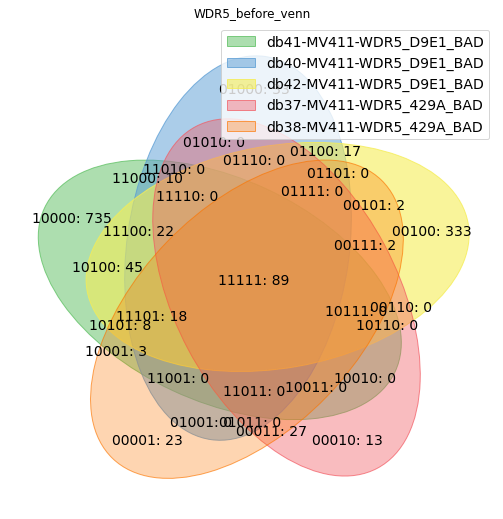

found total peak for this replicate set: [930 189 536 131 172]
no peaks were good enough quality
wrong TF: WDR5


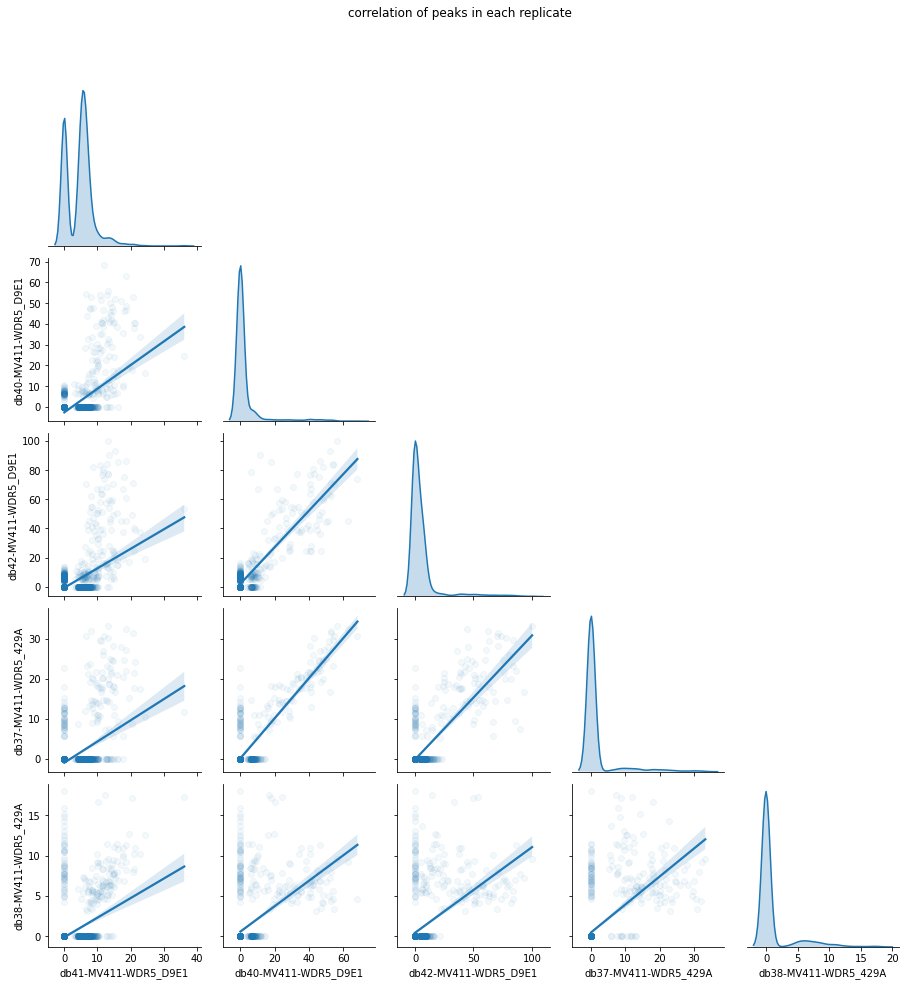

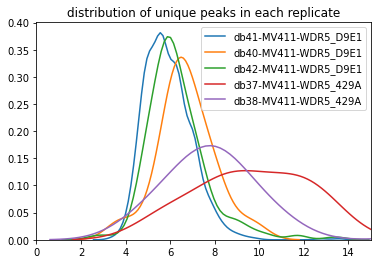

main rep is: db37-MV411-WDR5_429A
db41-MV411-WDR5_D9E1
overlap: 67.93893129770993%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.4154525625379515 17.371028849213786 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKB

5.502259352269049 50.60928508080302
we have recovered 149 peaks, equal to 56.015037593984964% of the peaks in main replicate
db42-MV411-WDR5_D9E1
overlap: 69.46564885496184%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

1.180432588934912 11.638413889775174 []
enough overlap
we have recovered 176 peaks, equal to 66.16541353383458% of the peaks in main replicate
db40-MV411-WDR5_D9E1
overlap: 67.93893129770993%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

0.9548841075870721 101.60991505981025 []
enough overlap
we have recovered 261 peaks, equal to 98.1203007518797% of the peaks in main replicate
db38-MV411-WDR5_429A
overlap: 90.07633587786259%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encounter

0.7325578447941812 41.93444630201859 []
enough overlap
we have recovered 437 peaks, equal to 164.28571428571428% of the peaks in main replicate


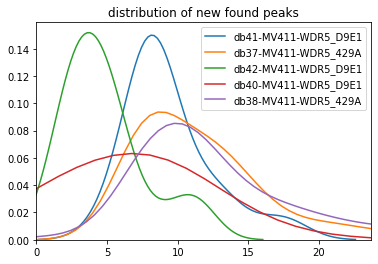

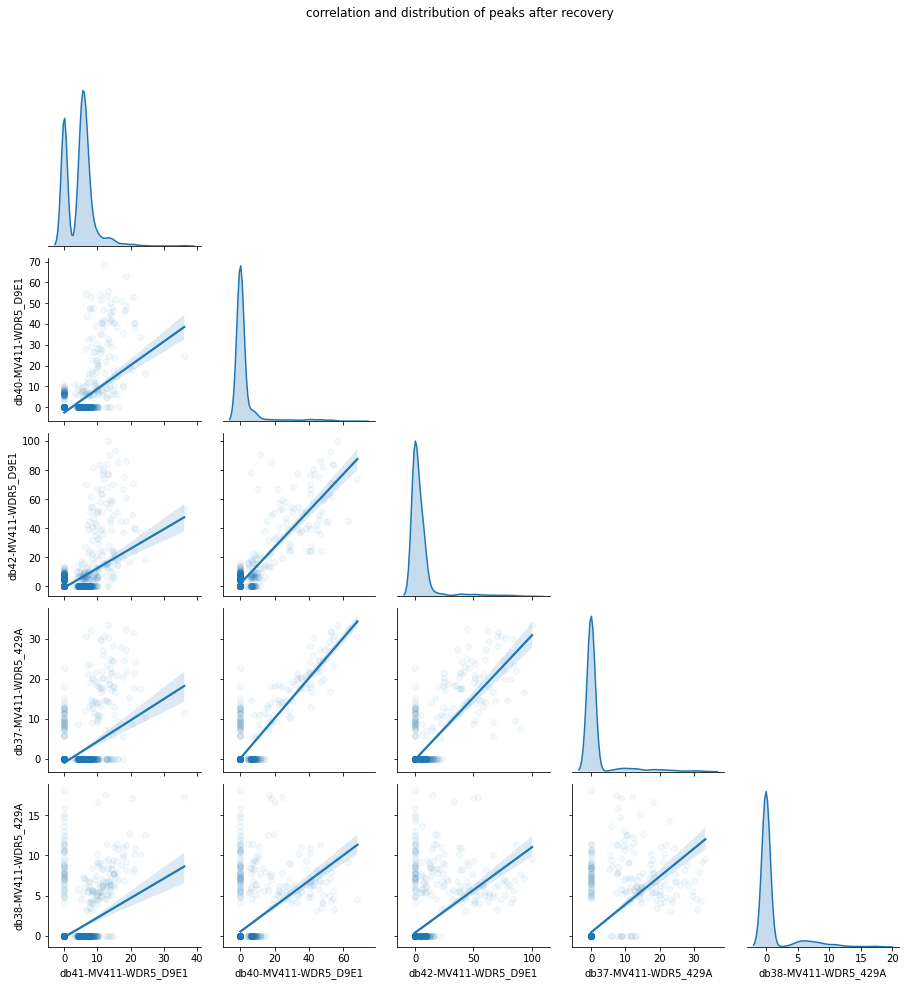

/home/jeremie/.local/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


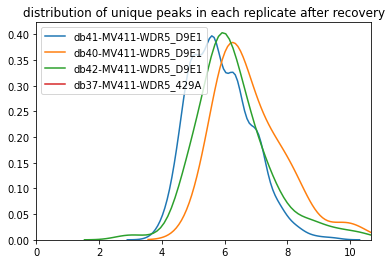

we only have one replicate for AFF4 .. pass
merging GATA2 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


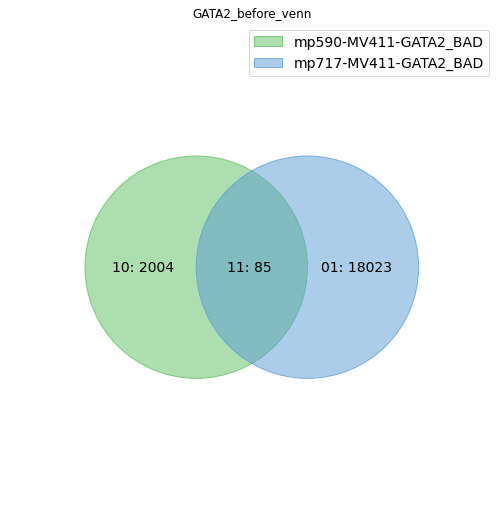

found total peak for this replicate set: [ 2089 18108]
no peaks were good enough quality
wrong TF: GATA2


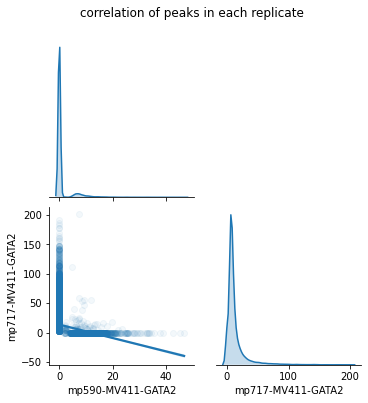

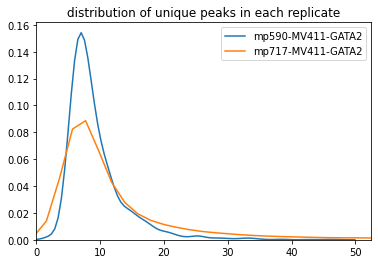

main rep is: mp590-MV411-GATA2
mp717-MV411-GATA2
overlap: 4.068932503590235%
not enough overlap
not using this replicate from the peakmatrix


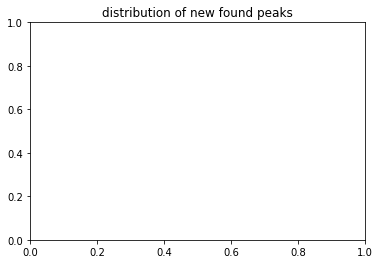

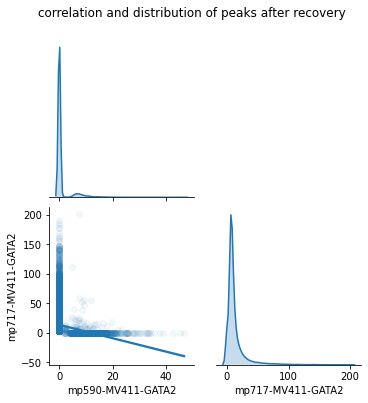

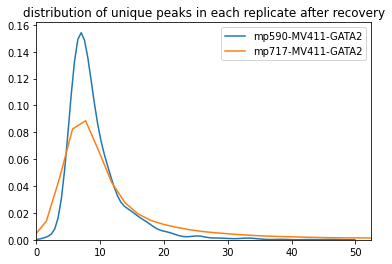

merging MEF2C peaks


finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


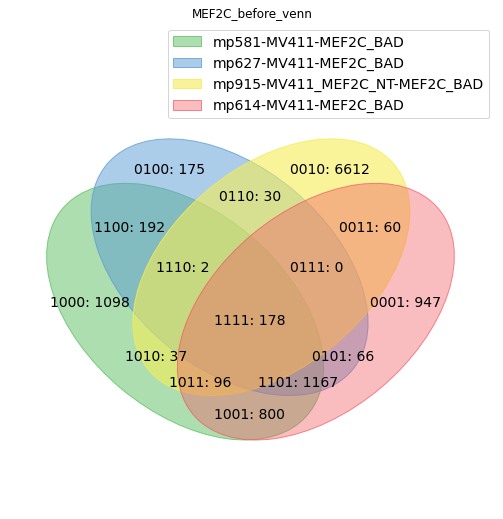

found total peak for this replicate set: [3570 1810 7015 3314]
no peaks were good enough quality
wrong TF: MEF2C


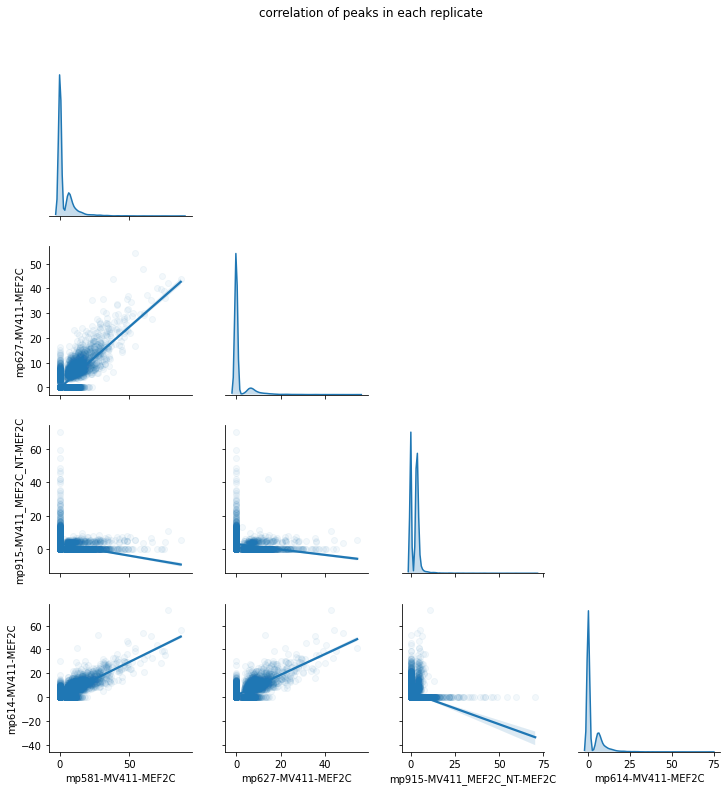

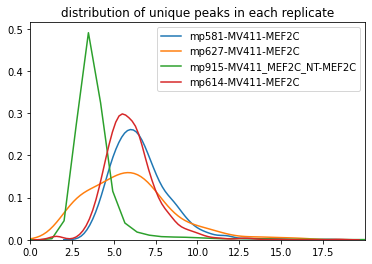

main rep is: mp627-MV411-MEF2C
mp915-MV411_MEF2C_NT-MEF2C
overlap: 11.602209944751381%
not enough overlap
not using this replicate from the peakmatrix
mp581-MV411-MEF2C
overlap: 85.02762430939227%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKB

0.927827578478974 70.81722184291493 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


6.469333753967152 40.24207040070285
we have recovered 312 peaks, equal to 16.032887975334017% of the peaks in main replicate
mp614-MV411-MEF2C
overlap: 77.95580110497238%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.332712886322032 73.15781831306433 []
enough overlap
we have recovered 451 peaks, equal to 23.175745118191163% of the peaks in main replicate


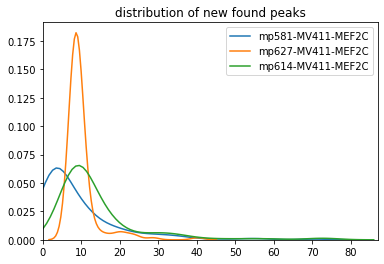

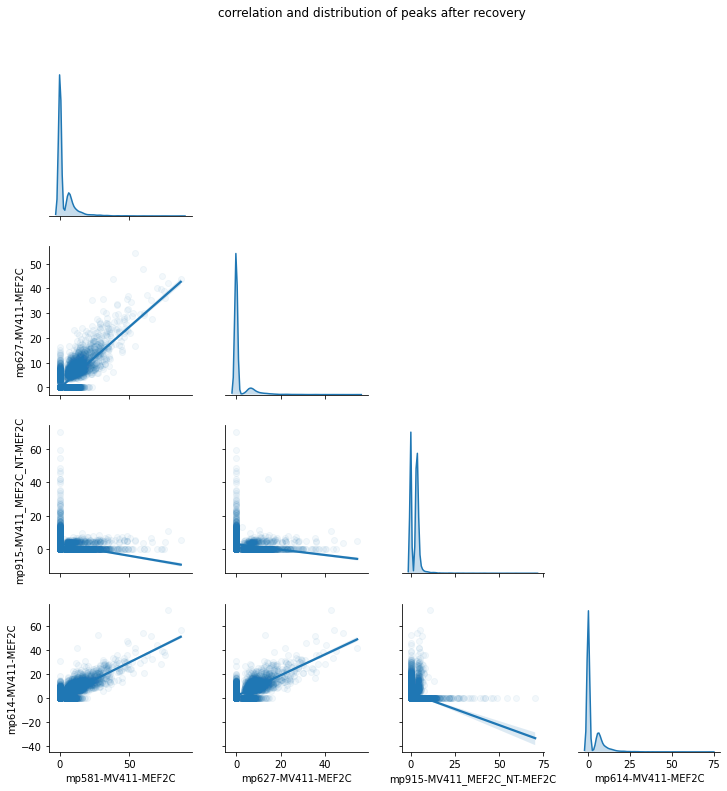

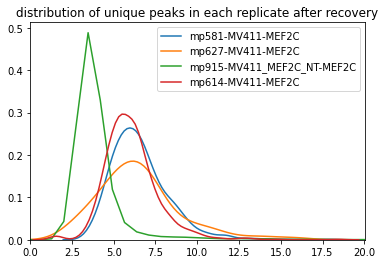

we only have one replicate for STAT5B .. pass
we only have one replicate for H3K27me3 .. pass
merging JUND peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


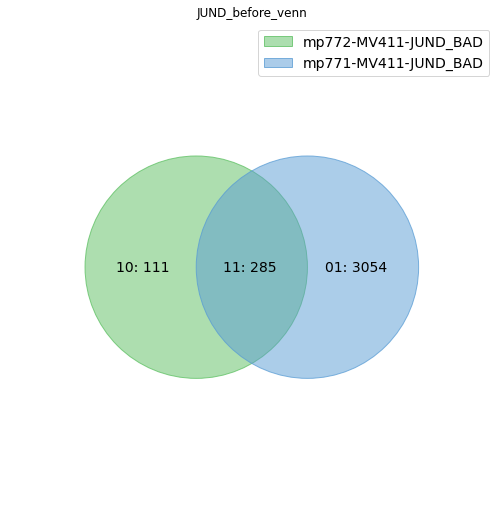

found total peak for this replicate set: [ 396 3339]
no peaks were good enough quality
wrong TF: JUND


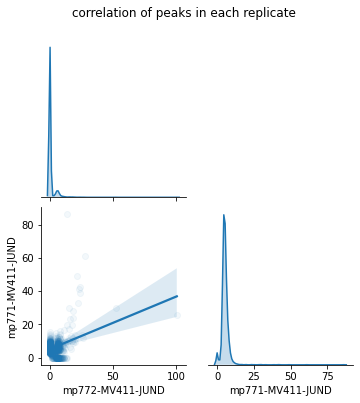

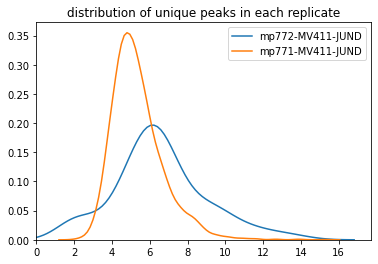

main rep is: mp772-MV411-JUND
mp771-MV411-JUND
overlap: 71.96969696969697%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_

5.372775976183079 79.70097316269296 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


5.812747900642794 26.166475217490035
we have recovered 405 peaks, equal to 52.66579973992198% of the peaks in main replicate


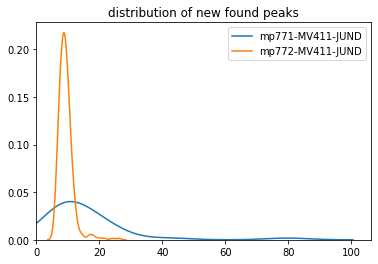

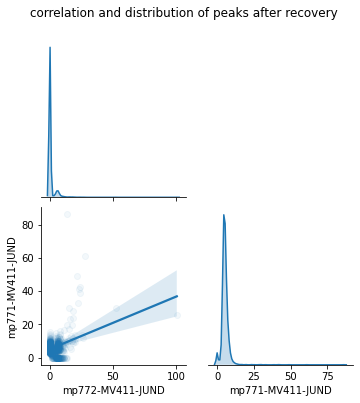

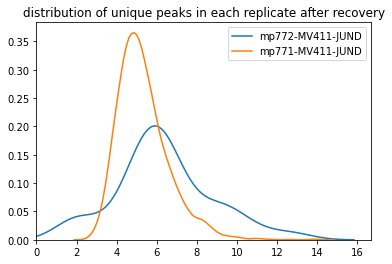

we only have one replicate for ZFP281 .. pass
we only have one replicate for RXRA .. pass
we only have one replicate for H3K36me2 .. pass
we only have one replicate for H3K79me2 .. pass
merging MYB peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


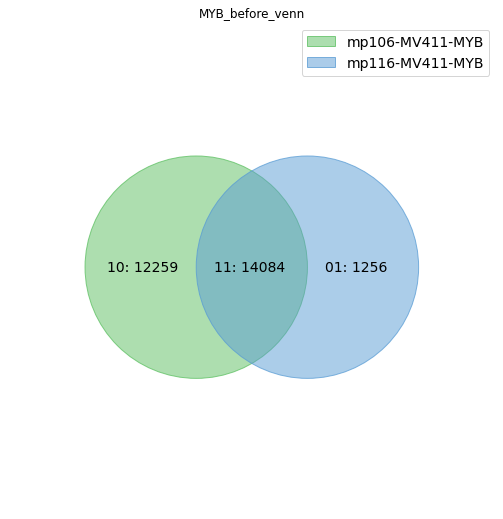

found total peak for this replicate set: [26343 15340]


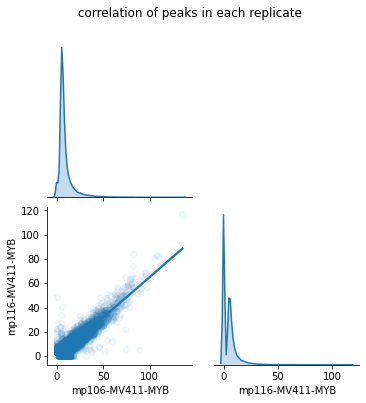

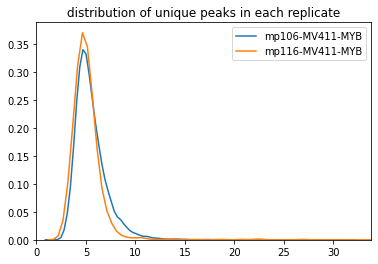

main rep is: mp106-MV411-MYB
mp116-MV411-MYB
overlap: 53.46391830846904%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)


5.513950298583058 52.193216210232755 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_

0.9097280405248419 66.08142568799634
we have recovered 212 peaks, equal to 0.8014213888783881% of the peaks in main replicate


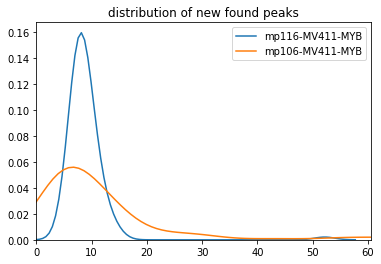

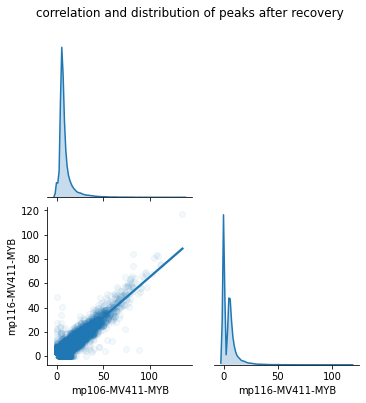

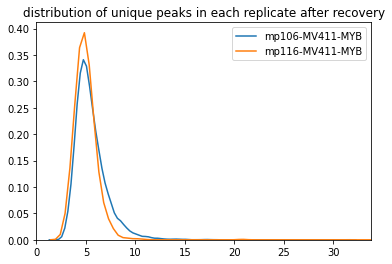

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


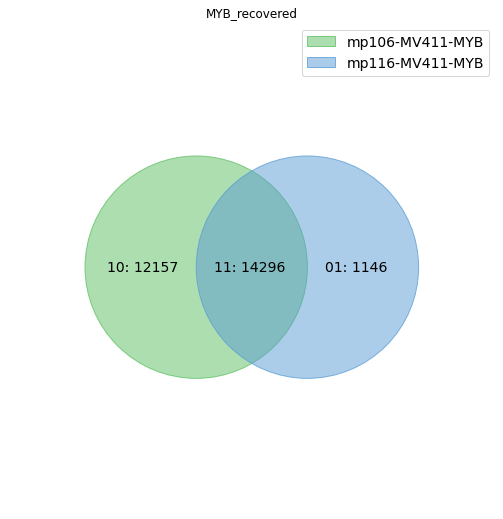

MYB 26453
merging GSE1 peaks


finish first overlaps lookup
!TF has less than 1000 PEAKS!


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


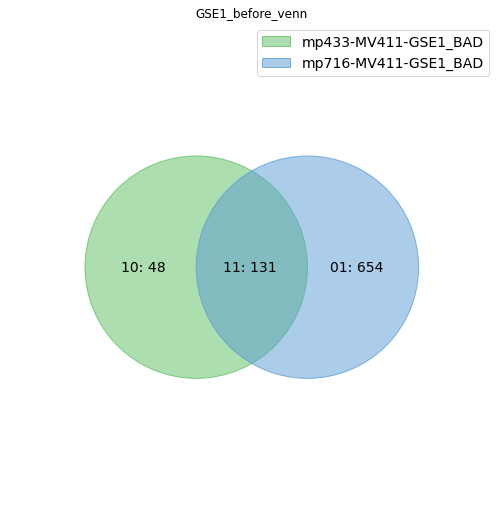

found total peak for this replicate set: [179 785]
no peaks were good enough quality
wrong TF: GSE1


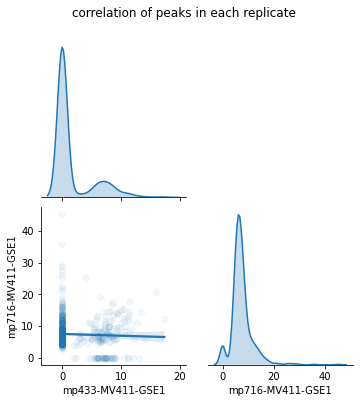

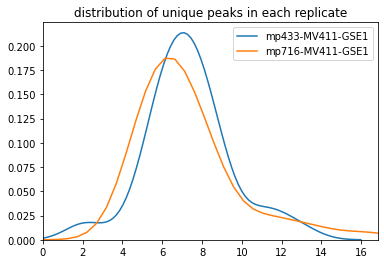

main rep is: mp433-MV411-GSE1
mp716-MV411-GSE1
overlap: 73.18435754189943%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)


6.8258870411537815 66.2275190278784
we have recovered 159 peaks, equal to 47.0414201183432% of the peaks in main replicate


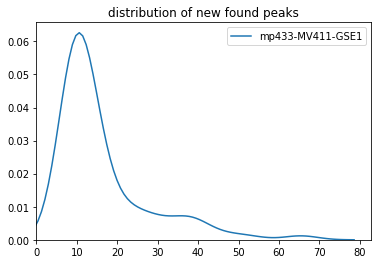

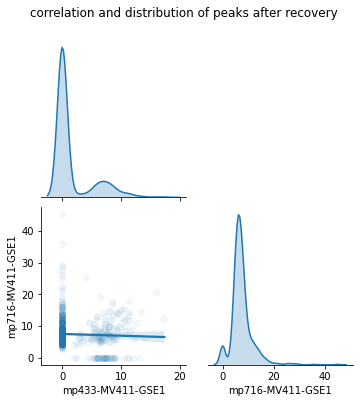

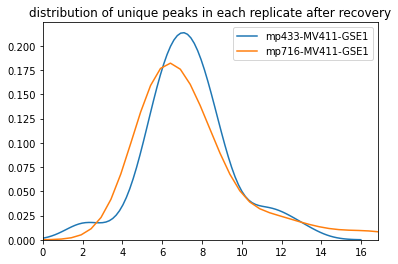

we only have one replicate for PSER2 .. pass
we only have one replicate for H3K9ac .. pass
merging BRD4 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


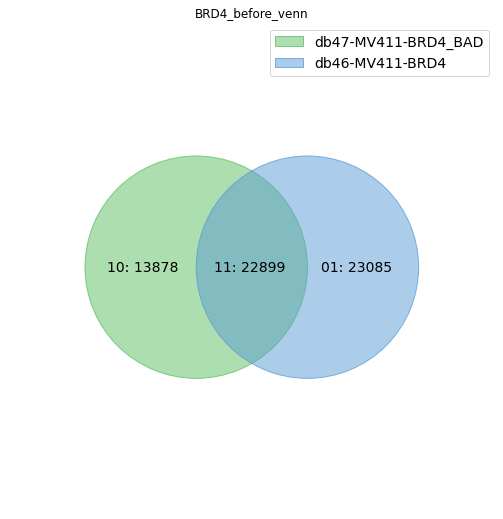

found total peak for this replicate set: [36777 45984]


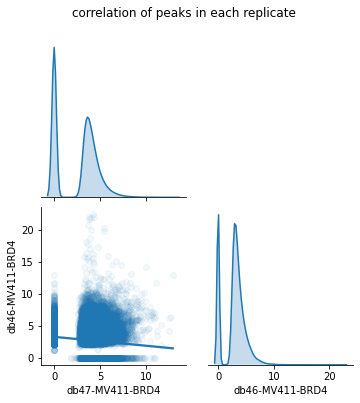

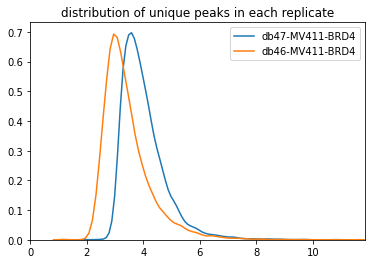

main rep is: db46-MV411-BRD4
db47-MV411-BRD4
overlap: 49.79775574112735%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.305181697194204 73.05909127906831 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_

1.0029430550860114 123.34353299865842
we have recovered 5237 peaks, equal to 10.254753372887661% of the peaks in main replicate


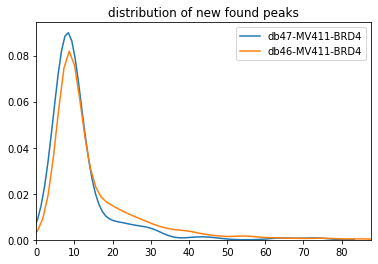

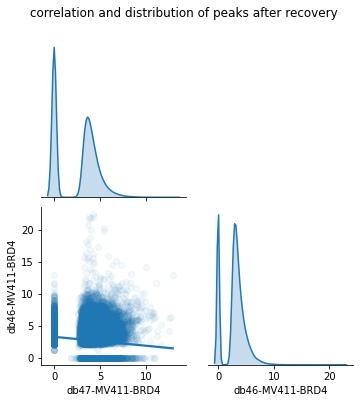

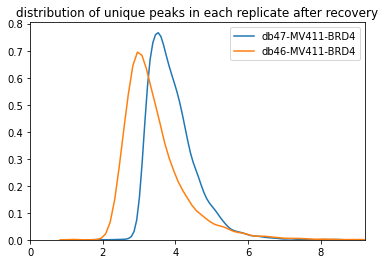

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


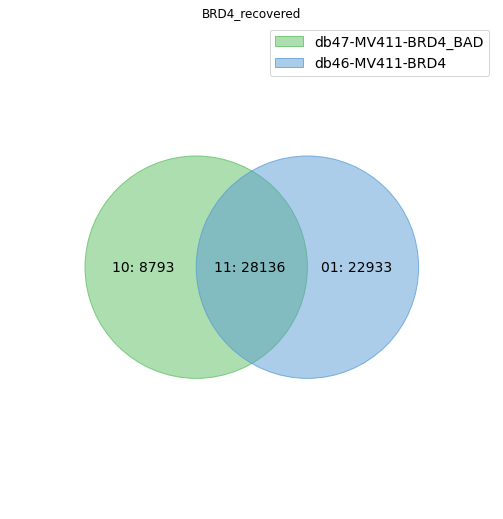

BRD4 51069
we only have one replicate for TFP4 .. pass
merging ELF2 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


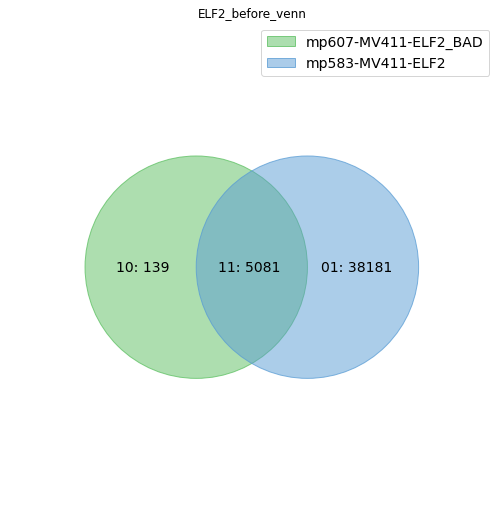

found total peak for this replicate set: [ 5220 43262]


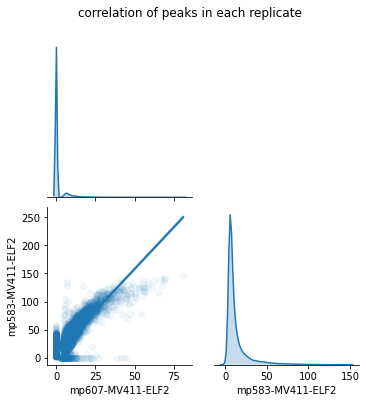

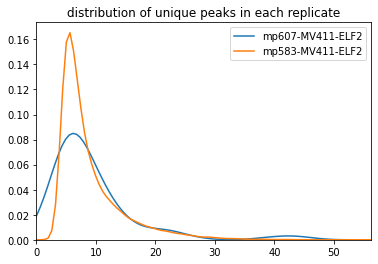

main rep is: mp583-MV411-ELF2
mp607-MV411-ELF2
overlap: 11.744718228468402%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

8.660037108107248 46.186857002214666 []
we did not had enough initial overlap.
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_

6.881924940535211 62.01872764516589 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.097705742351116 97.29502077559025
we have recovered 1378 peaks, equal to 3.111241561491048% of the peaks in main replicate
mp585-MV411-MYC
overlap: 39.509125528258956%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

6.398453643692144 43.22822277940829 []
enough overlap
we have recovered 1425 peaks, equal to 3.2173579282472735% of the peaks in main replicate


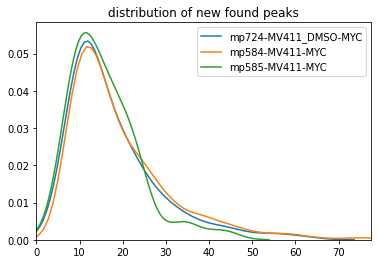

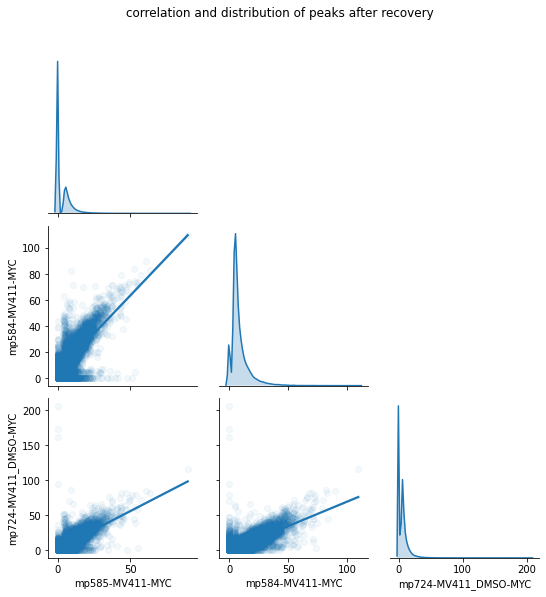

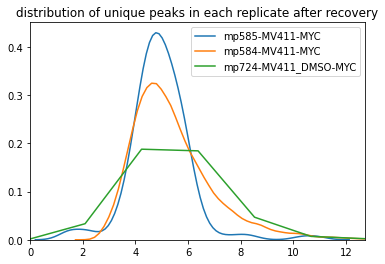

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


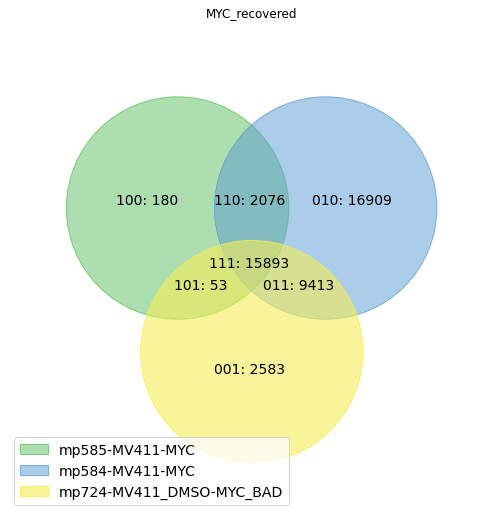

MYC 44291
we only have one replicate for SREBP1 .. pass
merging H3K27ac peaks


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2672: RuntimeWarning: invalid value encountered in double_scalars
  t *= temp*temp


3.86476594587691 34.76695754125517
we have recovered 8420 peaks, equal to 6.137876236505055% of the peaks in main replicate
mp183-MV411_DMSO-H3K27ac
overlap: 25.76804710230701%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

4.295878255326887 66.19761217804854 []
enough overlap
we have recovered 14264 peaks, equal to 10.397941405879823% of the peaks in main replicate
not enough overlap to advice to merge the bams.
oldnew overlap: 29.296331124572646%
                            new overlap: 29.296331124572646%
mp734-MV411_DMSO-H3K27ac
overlap: 21.91311121123491%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
../../JKBio/epigenetics/ChIP_helper.py:835: R

0.10252874499777165 76.61813610982885 []
enough overlap
we have recovered 48231 peaks, equal to 35.15865899796619% of the peaks in main replicate
mp702-MV411_DMSO-H3K27ac
overlap: 21.402225293816677%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
../../JKBio/epigenetics/ChIP_helper.py:835: R

0.17103892143839006 101.35630092319843 []
enough overlap
we have recovered 95948 peaks, equal to 69.94263053921462% of the peaks in main replicate
mp136-MV411-H3K27ac
overlap: 10.526999060703021%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.549607608409157 66.31397446936982 []
we did not had enough initial overlap.
enough overlap
we have recovered 96061 peaks, equal to 70.02500346257864% of the peaks in main replicate
enough from small overlap to advice to merge the peaks


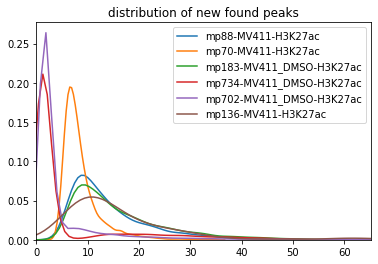

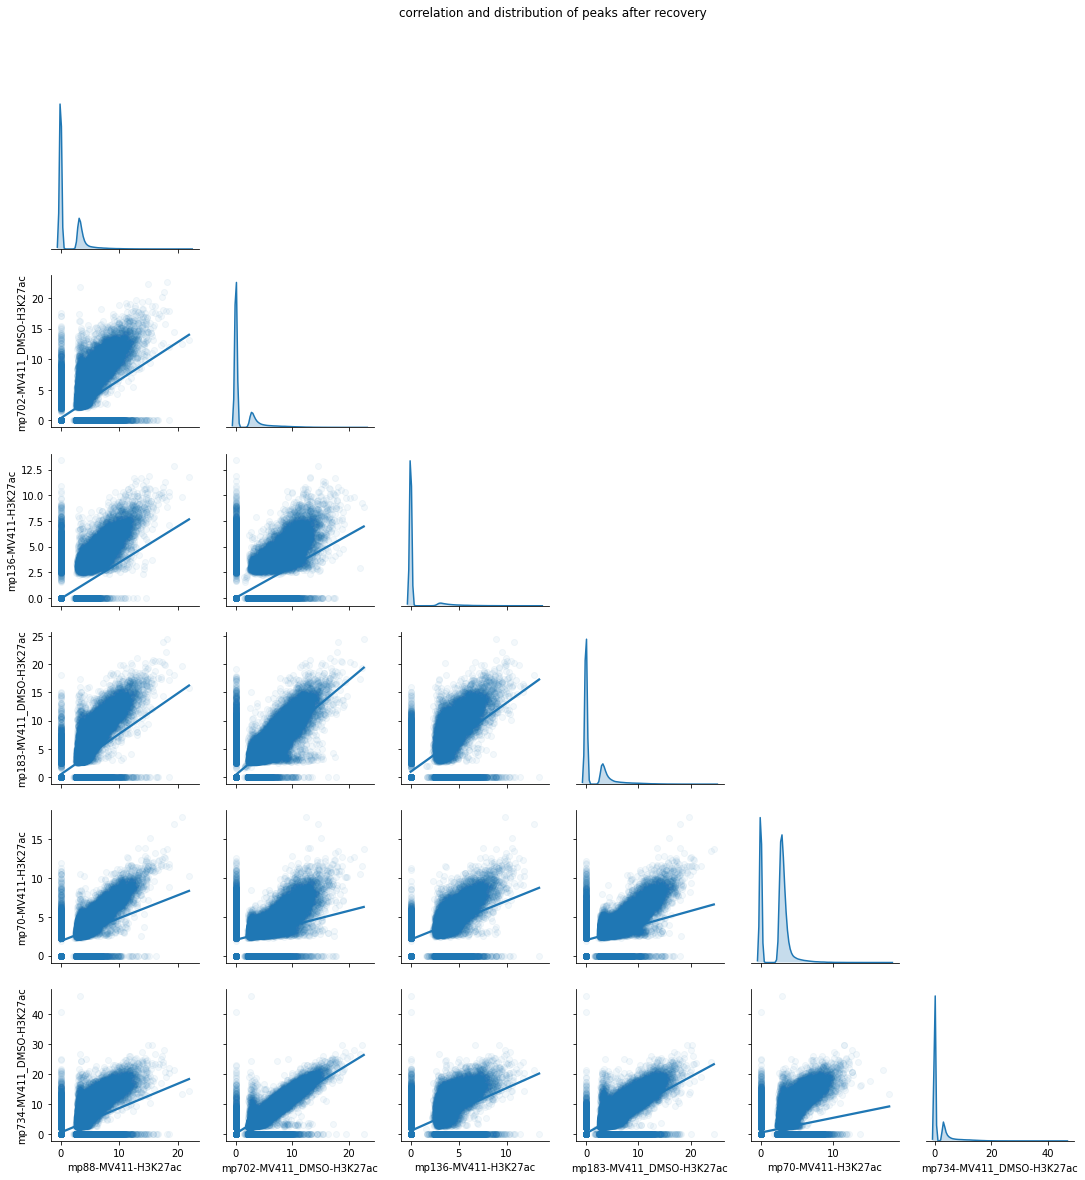

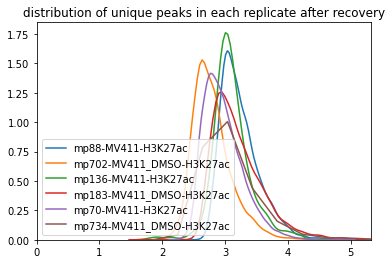

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn6()` is retained for backwards compatibility; use `venn()` instead
  warn((


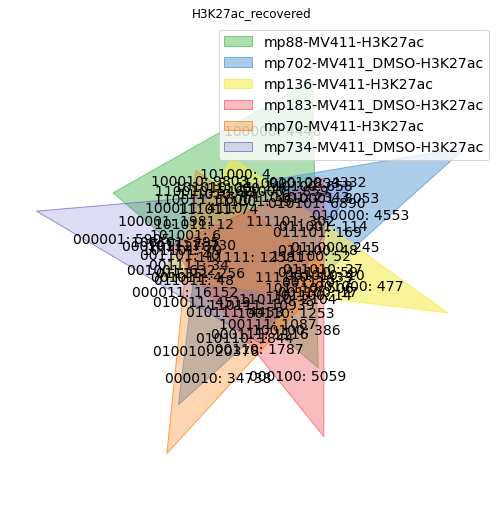

H3K27ac 170291
merging IRF2BP2 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


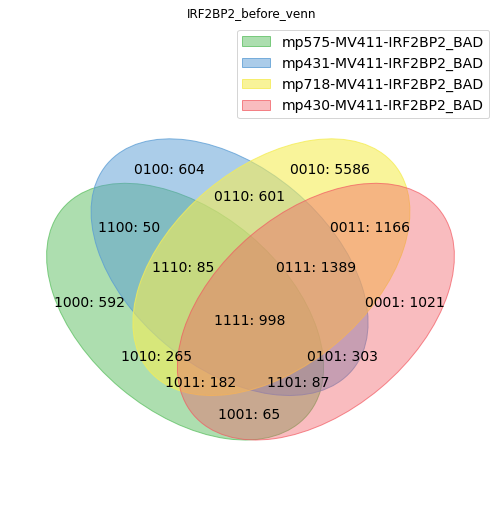

found total peak for this replicate set: [ 2324  4117 10272  5211]
no peaks were good enough quality
wrong TF: IRF2BP2


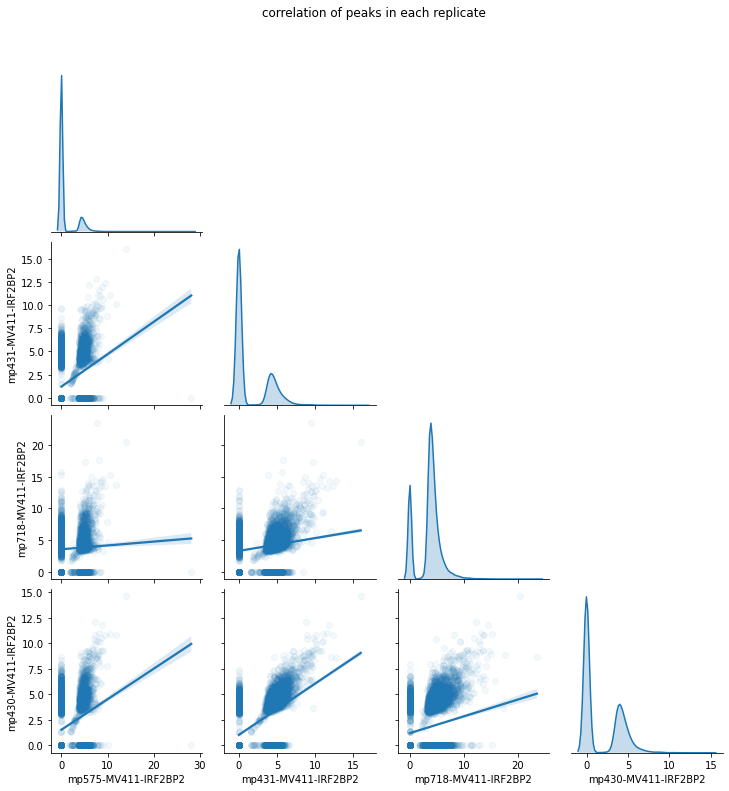

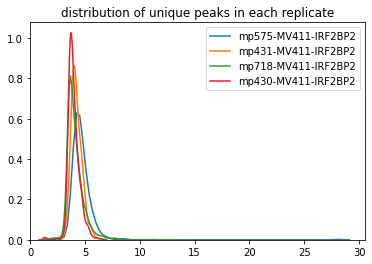

main rep is: mp575-MV411-IRF2BP2
mp718-MV411-IRF2BP2
overlap: 65.83476764199656%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site

6.561096283218694 95.2656348730189 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


7.178695758636794 37.3130776115444
we have recovered 145 peaks, equal to 6.136267456622937% of the peaks in main replicate
mp430-MV411-IRF2BP2
overlap: 57.31497418244407%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

5.377302341753139 74.54312104621668 []
enough overlap
we have recovered 304 peaks, equal to 12.865002115954296% of the peaks in main replicate
mp431-MV411-IRF2BP2
overlap: 52.49569707401033%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


5.577425461226521 39.09551385417364 []
enough overlap
we have recovered 470 peaks, equal to 19.889970376639866% of the peaks in main replicate


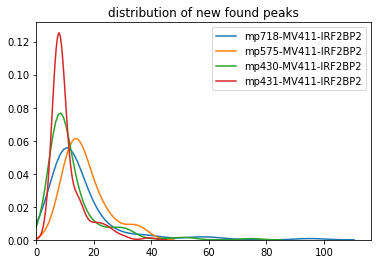

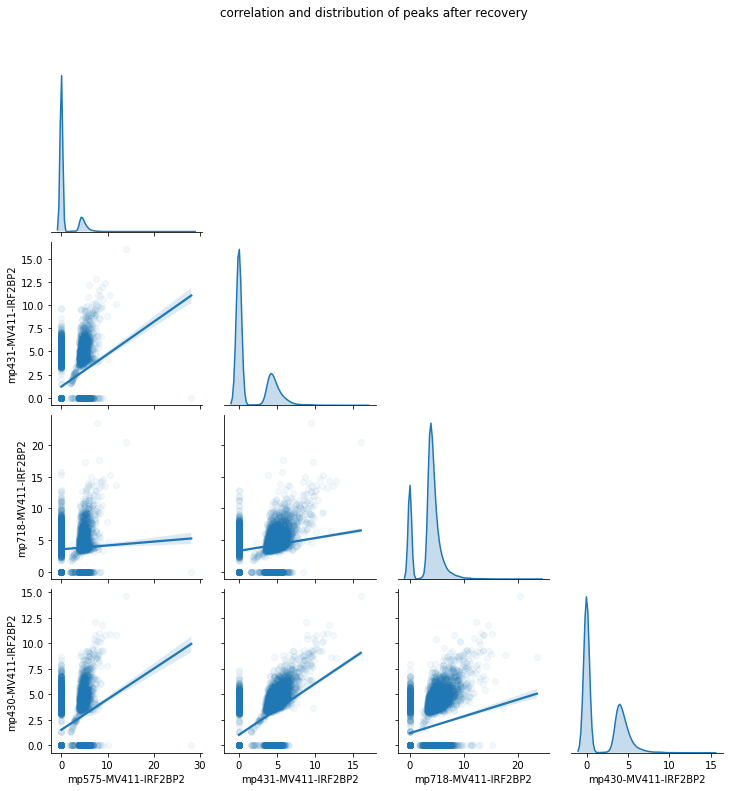

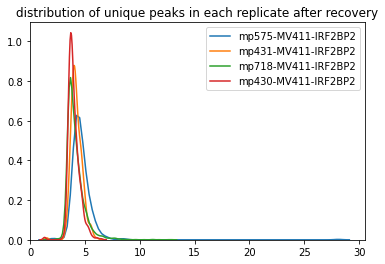

merging LMO2 peaks


0.36174053306705584

finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


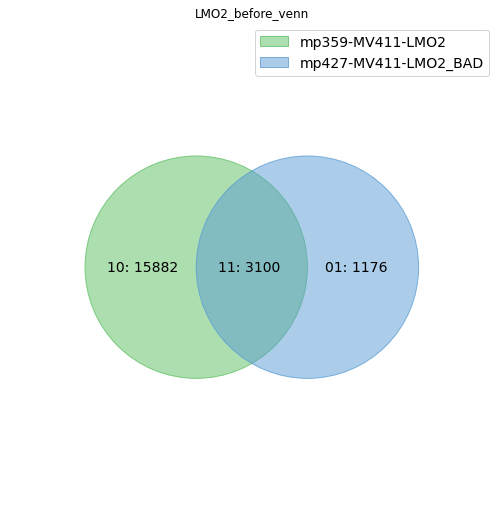

found total peak for this replicate set: [18982  4276]


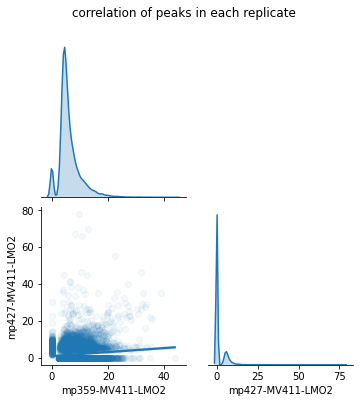

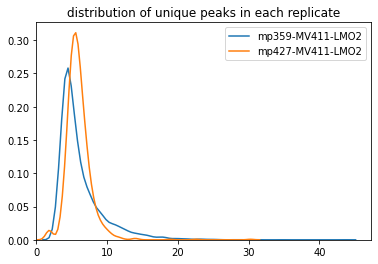

main rep is: mp359-MV411-LMO2
mp427-MV411-LMO2
overlap: 16.33126119481614%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


6.428105372122856 15.98414903939718 []
we did not had enough initial overlap.
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:836:

9.917975744529173 59.029113963084804
we have recovered 77 peaks, equal to 0.40475189234650966% of the peaks in main replicate
not enough overlap to advice to merge the bams.
oldnew overlap: 16.51564640185439%
                            new overlap: 16.69995794785534%


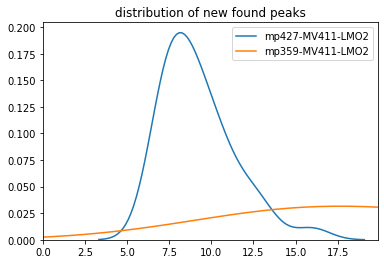

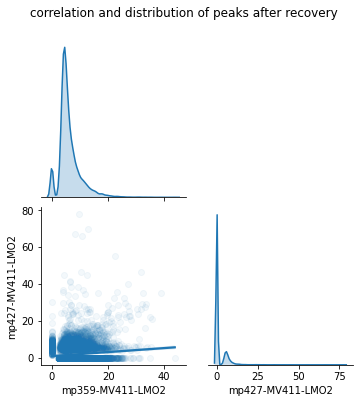

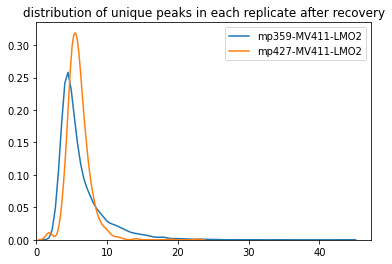

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


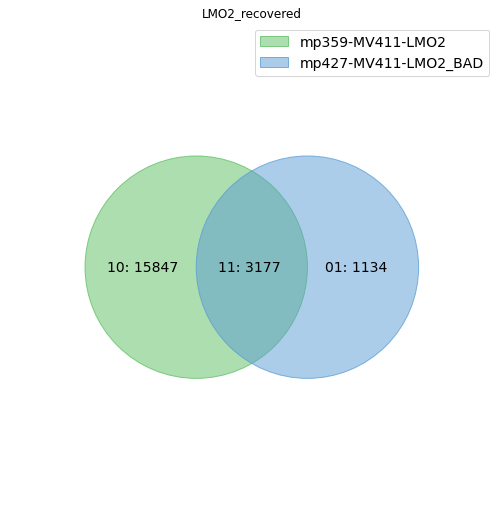

LMO2 19024
we only have one replicate for LYL1 .. pass
we only have one replicate for FLI1 .. pass
we only have one replicate for MED1 .. pass
we only have one replicate for CEBPB .. pass
merging SP1 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


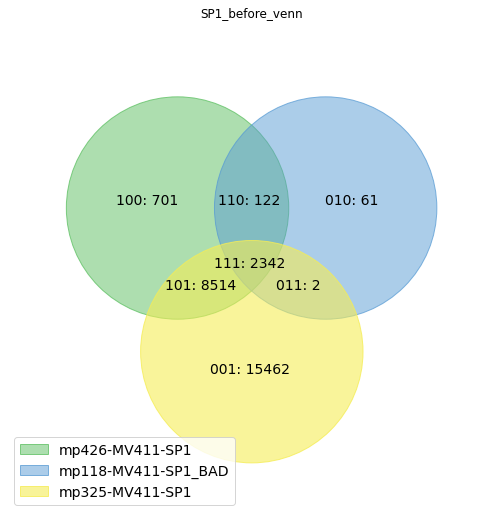

found total peak for this replicate set: [11679  2527 26320]


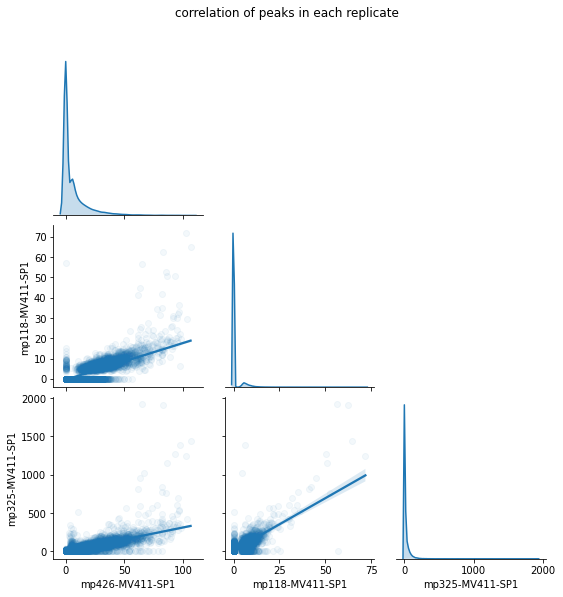

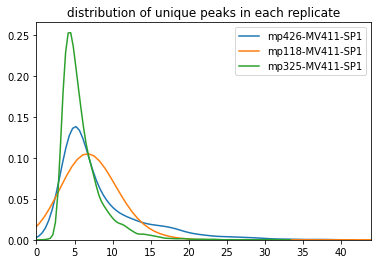

main rep is: mp325-MV411-SP1
mp426-MV411-SP1
overlap: 41.246200607902736%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_

0.7219125354815171 144.22503590935503 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: invalid value encountered in true_divide
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid 

0.7374187149707876 435.32644535293326
we have recovered 631 peaks, equal to 2.3520202773222008% of the peaks in main replicate
mp118-MV411-SP1
overlap: 8.905775075987842%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


9.419644485913134 39.6254183721475 []
we did not had enough initial overlap.
enough overlap
we have recovered 646 peaks, equal to 2.407932011331445% of the peaks in main replicate
enough from small overlap to advice to merge the peaks


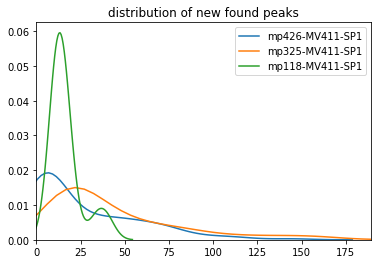

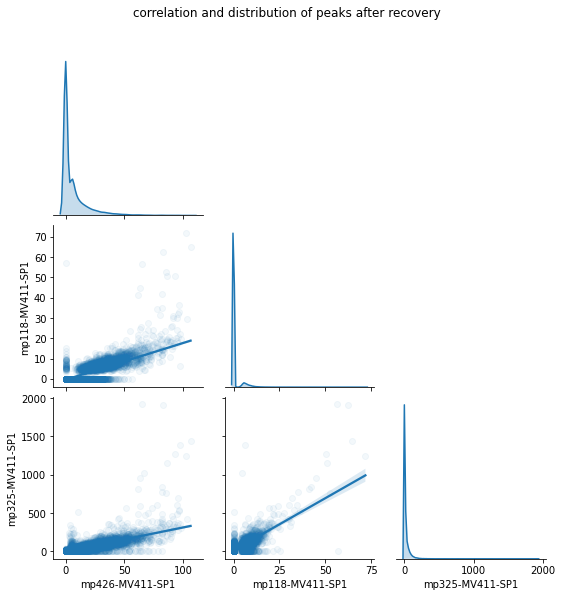

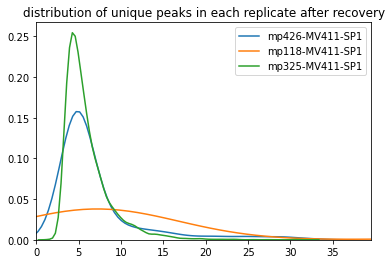

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


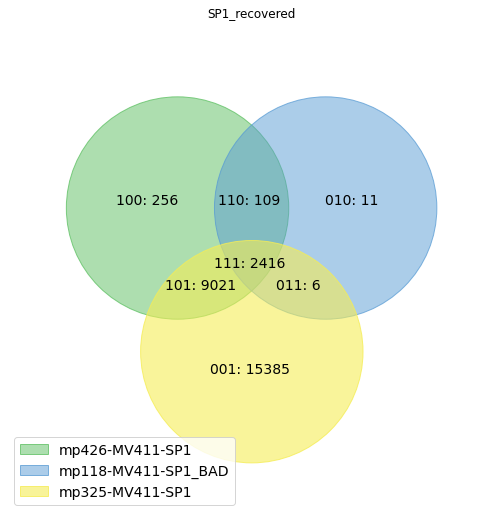

SP1 26828
we only have one replicate for FOSL2 .. pass
we only have one replicate for CTCF .. pass
merging PU1 peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


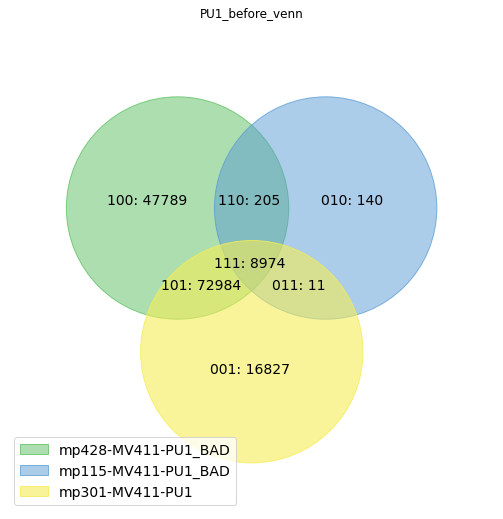

found total peak for this replicate set: [129952   9330  98796]


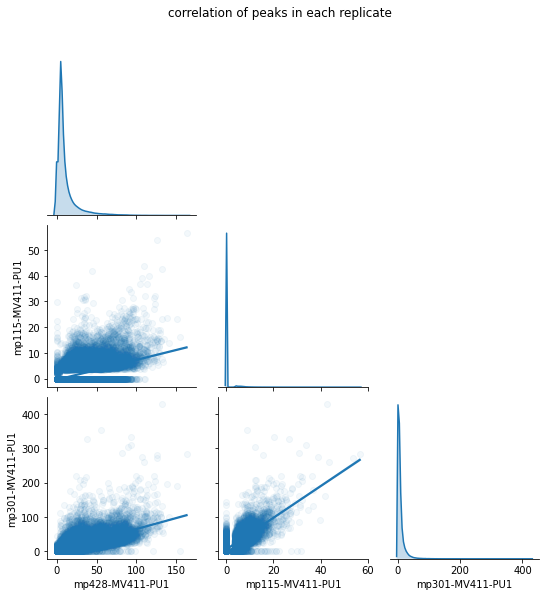

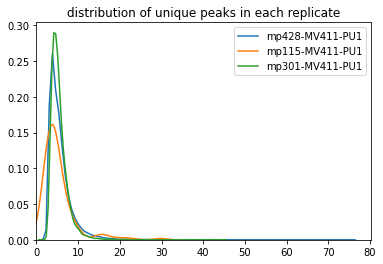

main rep is: mp301-MV411-PU1
mp428-MV411-PU1
overlap: 82.95679987044011%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/h

0.3210624373993328 159.20566713198377 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
../../JKBio/epigenetics/ChIP_helper.py:835: R

0.42484536574462095 354.95325619720865
we have recovered 21054 peaks, equal to 18.454499237417387% of the peaks in main replicate
mp115-MV411-PU1
overlap: 9.094497752945463%
not enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

11.003027949014133 16.1500907064007 []
we did not had enough initial overlap.
enough overlap
we have recovered 21059 peaks, equal to 18.458881896113457% of the peaks in main replicate
enough from small overlap to advice to merge the peaks


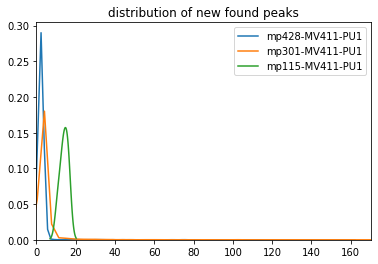

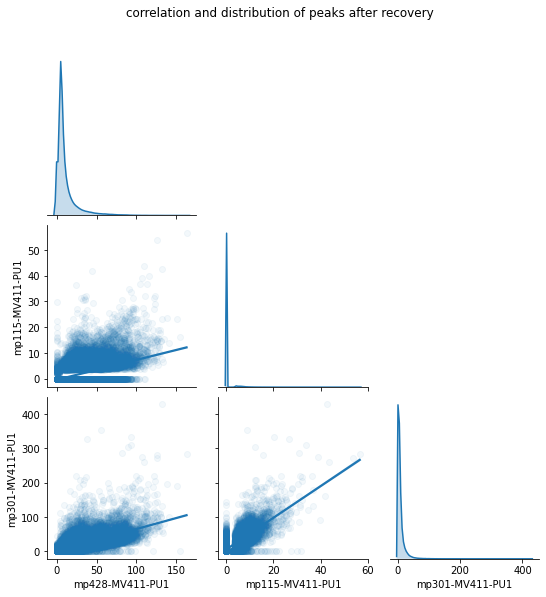

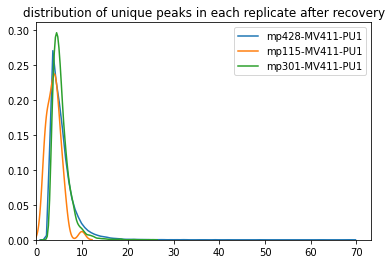

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  warn((


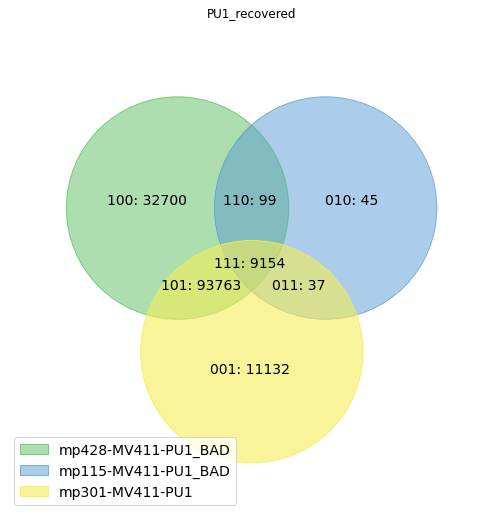

PU1 114086
we only have one replicate for GFI1 .. pass
merging CEBPA peaks
finish first overlaps lookup


/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


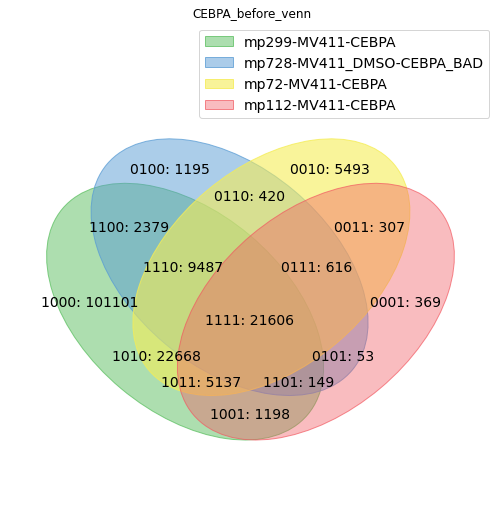

found total peak for this replicate set: [163725  35905  65734  29435]


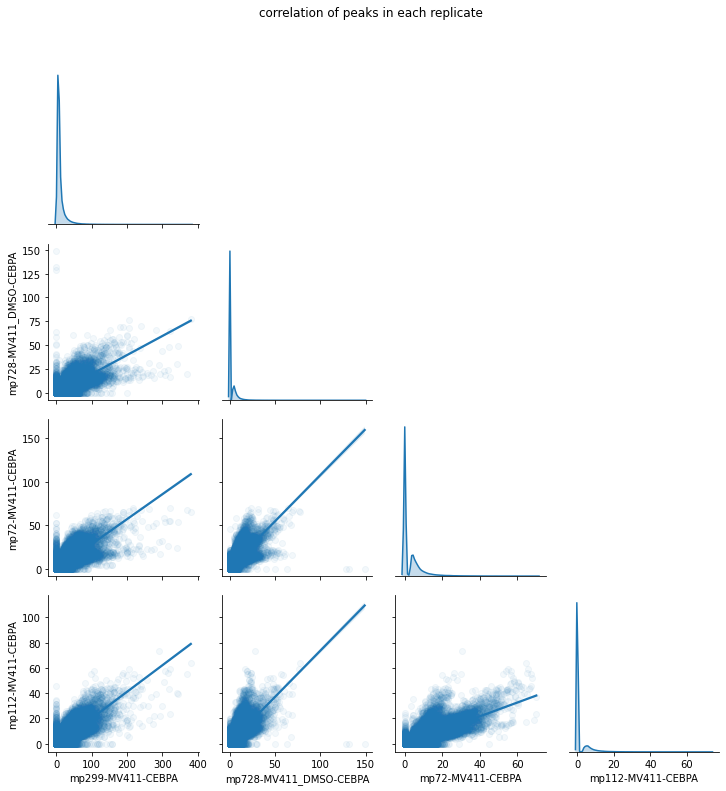

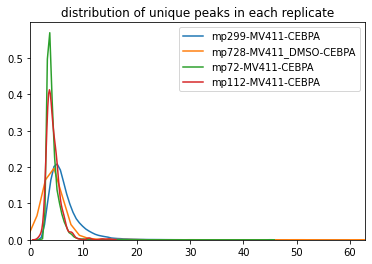

main rep is: mp299-MV411-CEBPA
mp72-MV411-CEBPA
overlap: 35.97373644831272%


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: invalid value encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
../../JKBio/epigenetics/ChIP_helper.py:834: RuntimeWarning: invalid value encountered in log
  # def poisson(k, lamb, scale): return scale * (lamb**k / factorial(k)) * np.exp(-lamb)
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in exp
  
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
../../JKB

7.652653582989175 49.164562820777846 []
enough overlap


../../JKBio/epigenetics/ChIP_helper.py:836: RuntimeWarning: divide by zero encountered in log
  def KLpoisson(lamb1, lamb2): return lamb1 * np.log(lamb1 / lamb2) + lamb2 - lamb1
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/home/jeremie/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2653: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
../../JKBio/epigenetics/ChIP_helper.py:835: RuntimeWarning: overflow encountered in power
  
../../JKBio/epigenetics/ChIP_helper.py:835: R

In [ ]:
%matplotlib inline
mergedpeak, tomergebam, remove, ratiosofunique = chiphelper.mergeReplicatePeaks(bindings,         '../../data/'+project+'/wigs/bigwig/',
        markedasbad=bad, window=150, mincov=4, doPlot=True, minKL=10, cov={}, 
        use='poisson', MINOVERLAP=0.25,lookeverywhere=True,
        only='',saveloc='../results/'+project+'/plots/'+version+'/')

In [ ]:
#list of bam files that are sufficiently similarr that we could directly merge them and call peaks on them again
tomergebam

In [ ]:
mergedpeak #= mergedpeak[mergedpeak.columns[[2,9,3,5,6,4,0,1,7,10]]]

In [ ]:
# TFs that you might want to remove because of their quality
remove

In [ ]:
mergedpeak.to_csv('../results/'+project+'/large/merged_replicates_'+version+'.csv.gz')

In [ ]:
mergedpeak = pd.read_csv('../results/'+project+'/large/merged_replicates_'+version+'.csv.gz', index_col=0)

## sorting and removing samples

In [ ]:
bigwigs=os.listdir('../../data/bigwig/')
for val in bigwigs:
    for v in remove + toremove + ['scale','POLII','IGG','CTCF','INPUT']:
        if v in val:
            bigwigs.remove(val)
            break
bigwigs = ['data/bigwig/'+ i for i in bigwigs]

In [ ]:
set(mergedpeak.tf)

In [ ]:
mergedpeak.foldchange.min()

In [ ]:
mergedpeak['name']=mergedpeak.tf

In [ ]:
## Removing bad ChIP protein
mergedpeak = mergedpeak[~mergedpeak['name'].isin(['CDK13','GSE1'])]

## Consensus set

In [ ]:
window = 150

In [3]:
merging_version = "simpleMerge"

In [ ]:
merged = chiphelper.simpleMergePeaks(mergedpeak[~mergedpeak.tf.isin(['MED1','SMC1','CTCF','POLII','IRF2BP2_FLAG','IRF2BP2', 'H3K27ac', 'H3K27me3', 'H3K4me3', 'H3K79me2','H3K36me3', 'H3K4me1','H3K18','H3K9ac','H3K36me2','PU1_FLAG','PU1','CEBPA','CEBPB'])], window=window)

In [ ]:
window=str(window)
len(merged),len(mergedpeak)

In [ ]:
merged

In [ ]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t',index=None)

In [ ]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t')

## Plotting similarity kernels over TF binding profiles

select a set of TFs to compare

In [ ]:
cols = [8]
#cols = merged.columns[cols]

In [ ]:
fig = sns.pairplot(merged[cols], corner=True, diag_kind="kde", kind="reg", plot_kws ={"scatter_kws":{"alpha":.05}})
def col_nan_scatter(x,y, **kwargs):
    df = pd.DataFrame({'x':x[:],'y':y[:]})
    df = df[df.sum(0)!=0]
    x = df['x']
    y = df['y']
    plt.gca()
    plt.scatter(x,y)
def col_nan_kde_histo(x, **kwargs):
    df = pd.DataFrame({'x':x[:]})
    df = df[df['x']!=0]
    x = df['x']
    plt.gca()
    sns.kdeplot(x)
fig = fig.map_upper(col_nan_scatter)
fig = fig.map_upper(col_nan_kde_histo)
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_pairplot_experiments.pdf')
plt.show()
counts,val = np.unique(merged[merged.columns[8:]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'pairplot_experiments.pdf')
plt.show()
i = merged[merged.columns[8:]].astype(bool).sum(1)
print(i.max(),i.mean(),i.min())

## Comparison to a random distribution 

### computation:

we are evalutating each event's probability 1 binding, 2 binding, n binding.., as a binomial over the amount of proability p_i with n retries corresponding to the size of the conscensus peak set.
the probability p_i of this binomial is the sum of probabilities of having tf a binding with b for all possible combination of tf. 
the number of combination is k amongst n, n being 33, k going from 1 to 29
we compute 

$p(a & b) = p(a)\*p(b) =p(ab)$

and 

$p(a & b) | p(a & c) = p(ab) + p(ac) - p(abc)$

for a,b,c,d:

$p(ab) + p(ac) + p(ad) + p(bc) + p(bd) + p(cd) - {3\choose 2}*(p(abc) - p(abd) - p(bcd) - p(acd)) - {4\choose 2}*p(abcd)$

In [ ]:
#we are looking at the distribution of pseudo-enhancers per cobound regions
counts,val = np.unique(merged[merged.columns[8:]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.figure.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_distribution.pdf")

now we will be making the expected distribution

In [ ]:
size=30
proba = (merged[merged.columns[8:]].astype(bool).sum(0)/len(merged)).tolist()
sums = {i:0 for i in range(1,size)}
for i in range(size-1,0,-1):
    print(i)
    if sums[i]> 0:
        continue
    print(helper.combin(33,i))
    v=0
    for j in itertools.combinations(proba, i):
        v+=np.prod(j) 
    sums[i] = v
for i in range(size-1,0,-1):
    for j in range(i+1,sze):
        icomb = helper.combin(j,i)
        sums[i] -= icomb*sums[j]
sums[0] = 1-sum(list(sums.values()))

In [ ]:
for i in range(29,0,-1):
    print(i,stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i]))
    sums[i] = [stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i])]

In [ ]:
version = "v2"
merging_version = "simpleMerge"
window = "150"
a = '../results/' + project + '/*_sums.json'
!ls $a

In [ ]:
helper.dictToFile(sums,'../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')

In [ ]:
sums = helper.fileToDict('../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')
sums

In [ ]:
cobind = pd.DataFrame(sums).T.rename(columns={0:'mean',1:'var'})

In [ ]:
merged[merged.columns[8:]].astype(bool).sum().sum(), (val*counts).sum(), cobind.sum()

let's look at the expected distribution

In [ ]:
cobind['cobinding']=cobind.index
fig = sns.barplot("cobinding","mean", data=cobind, ci=None)
plt.errorbar(x=range(0,len(cobind)),y=cobind['mean'],
            yerr=cobind['var'], fmt='none', c= 'r')
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_expected_cobinding_distribution.pdf")

Let's look at the enrichment of our current dataset

In [ ]:
res = pd.DataFrame()
res['change']=val/cobind['mean']
res['count']=list(res.index)
fig = sns.barplot(data=res.T).set_yscale("log")
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment.pdf")

now plotting the enrichment

In [ ]:
fig = plt.bar(res['count'],res['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window + "_cobinding_enrichment_matplotlib.pdf")
plt.show()

In [ ]:
m =12
fig = plt.bar(res.iloc[:m]['count'],res.iloc[:m]['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment_zoomed.pdf")
plt.show()

## The cobinding Matrix

In [ ]:
merged.columns[8:]

In [ ]:
merging_version = "remove_single"

In [ ]:
#merged = merged.drop(columns='PU1_FLAG')
merged = merged[merged[merged.columns[8:]].astype(bool).sum(1)>1]

In [ ]:
merged[merged.columns[:8]].to_csv('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_conscensus.bed.gz',sep='\t',index=None, columns=None)

### correlations over cobindings

In [ ]:
#raw correlation over cobindings
fig = sns.clustermap(np.corrcoef(stats.zscore(merged[merged.columns[8:]].values.T, axis=1)), figsize=(20, 20), xticklabels=merged.columns[8:], yticklabels=merged.columns[8:])
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("raw correlation over cobindings")
fig.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_correlation_cobinding_regular.pdf")

In [ ]:
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

In [ ]:
#clustermap of cobindings
fig = sns.clustermap(merged[merged.columns[8:]].loc[rand].T, standard_scale=0, figsize=(30,20),xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled.pdf')
plt.show()

## Peak annotations

In [ ]:
additional = {}
additional['activation'] = chiphelper.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(["H3K27ac",'H3K79me2','H3K36me3','H3K4me3','H3K9ac','H3K4me1'])], window=10, mergedFold="max")
additional['repression'] = mergedpeak[mergedpeak.tf.isin(['H3K27me3','H3K36me2'])
additional['IRF2BP2'] = mergedpeak[mergedpeak.tf=='IRF2BP2_FLAG']
additional['MED1'] = mergedpeak[mergedpeak.tf=='MED1']
additional['SMC1'] = mergedpeak[mergedpeak.tf=='SMC1']
additional['CTCF'] = mergedpeak[mergedpeak.tf=='CTCF']
additional['POLII'] = mergedpeak[mergedpeak.tf=='POLII']
additional['H3K18'] = mergedpeak[mergedpeak.tf=='H3K18']
additional['H3K36me2'] = mergedpeak[mergedpeak.tf=='H3K36me2']
additional['WDR5'] = mergedpeak[mergedpeak.tf=='WDR5']
additional["H3K27ac"] =mergedpeak[mergedpeak.tf=='H3K27ac']
additional["H3K79me2"] =mergedpeak[mergedpeak.tf=='H3K79me2']
additional["H3K36me3"] =mergedpeak[mergedpeak.tf=='H3K36me3']
additional["H3K4me3"] =mergedpeak[mergedpeak.tf=='H3K4me3']
additional["H3K9ac"] =mergedpeak[mergedpeak.tf=='H3K9ac']
additional["H3K4me1"] =mergedpeak[mergedpeak.tf=='H3K4me1']
additional["KMT2A"] =mergedpeak[mergedpeak.tf=='KMT2A']

In [ ]:
for key, val in additional.items():
    if len(val)>1:
        merged[key] = chiphelper.putInConscensus(merged[merged.columns[:8]],val)
        merged = merged.replace(np.nan,0)
        merged[key].astype(bool).sum()

### adding ATACseq

In [ ]:
ATAC= chiphelper.loadPeaks(peakFile = '../data/' + project + '/BroadPeaks/ATAC_MV411.mRp.clN_peaks.broadPeak')
merged['ATAC'] = chiphelper.putInConscensus(merged[merged.columns[:8]],ATAC)
merged = merged.replace(np.nan,0)
merged['ATAC'].astype(bool).sum()

### compute promoters

In [ ]:
promoters = pd.read_csv('../data/'+project+'/compute_genes/human_epdnew_TeLy2.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)
promoters['foldchange']=1
promoters['name']=[i[:-2] for i in promoters['name']]
merged['promoters'] = chiphelper.putInConscensus(merged[merged.columns[:8]],promoters)
merged = merged.replace(np.nan,0)
merged['promoters'].astype(bool).sum()

### adding super enhancers

In [ ]:
set(bindings[bindings.tf=="H3K27ac"].name)

In [ ]:
! mkdir ../../data/$project/MV411_H3K27ac
! cp ../../$project/BroadPeaks/*MV411*H3K27* ../../data/$project/MV411_H3K27ac/

In [ ]:
peaks = ! ls ../../data/$project/MV411_H3K27ac/*.broadPeak
for val in peaks:
    valbed = val +".bed"
    ! mv $val $valbed

In [ ]:
! mkdir ../../results/$project/ROSE/MV411/
for peak in peaks[1:]:
    chiphelper.MakeSuperEnhancers(peak+'.bed',
                             bamFile='.'.join(peak.split('.')[:-1])+'.mLb.clN.sorted.bam',
                             baiFile='.'.join(peak.split('.')[:-1])+'.mLb.clN.sorted.bam.bai',
                             controlBam= '../../data/diffBinding_hist/INPUT_R1.mLb.clN.sorted.bam',
                             controlBai= '../../data/diffBinding_hist/INPUT_R1.mLb.clN.sorted.bam.bai',
                             outdir ='../results/'+project+'/ROSE/MV411/',
                             rosePath="../src/ROSE/")

In [ ]:
! rm ../data/$project/MV411_H3K27ac/*.bam*

In [ ]:
rose = chiphelper.ReadRoseSuperEnhancers("../results/"+project+"/ROSE/MV411/")

In [ ]:
rose = chiphelper.simpleMergePeaks(rose,window=1000).drop(columns=["relative_summit_pos","-log10pvalue","-log10qvalue"])

In [ ]:
rose = rose[rose[rose.columns[5:]].astype(bool).sum(1)>1]
rose = rose.sort_values(by=['chrom','start','end']).reset_index(drop=True)

In [ ]:
merged['super_enhancer'] = chiphelper.putInConscensus(merged[merged.columns[:8]],rose)
merged = merged.replace(np.nan,0)

In [ ]:
merged['super_enhancer'].astype(bool).sum()

In [ ]:
## making regulat enhancers merged["regular_enhancers"]
merged['regular_enhancer'] = (merged['activation'].astype(bool) & ~merged[['super_enhancer','promoters']].astype(bool).sum(1).astype(bool)).astype(float)

In [ ]:
set(mergedpeak.tf)

### adding ATACseq datta

In [ ]:
! cp ../temp/MV411Merged/ATAC.bed ../../data/ATACseq/ATAC_MV411.mRp.clN_peaks.broadPeak 

In [ ]:
#! mkdir ../results/$project/MV411Merged
for i in set(mergedpeak.tf):
    a = mergedpeak[mergedpeak.tf==i][['chrom','start',"end",'peak_number',"foldchange"]]
    a['strand']='+'
    a.to_csv("../results/"+project+"/"+version+'_'+merging_version+'_'+window+"_ MV411Merged/"+i+'.bed', sep='\t', index=False)

In [ ]:
a = ATAC[['chrom','start',"end","peak_number",'foldchange']]
a['strand'] = '+'
a.to_csv('../results/'+project+"/"+version+'_'+merging_version+'_'+window+'_MV411Merged/ATAC.bed',index=False,sep='\t')

### Running and adding ChromHMM

In [ ]:
l = ['H3K27ac', 
     'H3K27me3', 
     "H3K79me2",
     "H3K18",
     "H3K4me1",
     "H3K36me3",
     "H3K4me3", 
     "H3K9ac",
     "H3K36me2",
     "CTCF", 
     'SMC1', 
     "POLII", 
     "MED1", 
     'ATAC', 
     'CEBPA',
     "CEBPB",
     "PU1_FLAG",
     'KMT2A',
     'WRD5']

In [ ]:
## computing CHROMHMM
#!mkdir ../results/chromHMM/
chrombed = chiphelper.runChromHMM(numstates=8, outdir = '../results/chromHMM/' + version + '_'+merging_version+'_'+window+'_/', data = pd.DataFrame([['MV411'] * len(l), l,["AMLproject/results/" + project + "/" + version + '_' + merging_version + '_'+window+'_MV411Merged/'+i+'.bed' for i in l]]).T, datatype = 'bed', folderPath="", chromHMMFolderpath="../src/Chro mHMM/", control_bam_dir = None)['MV411']

In [ ]:
from IPython.display import Image, display
im = ! ls ../results/$project/chromHMM/v2_all_$window/*.png
for val in im:
    display(Image(filename=val))

In [ ]:
version = "v2"
merging_version = "all"
window = "150"

In [ ]:
chrombed = pd.read_csv('../results/'+project+'/chromHMM/'+version+'_'+merging_version+'_'+window+'/MV411_8_dense.bed',sep='\t',header=None, skiprows=1).drop(columns=[4,5,6,7]).rename(columns={0:'chrom',1:'start',2:'end',3:'state',8:"color"})

In [ ]:
chrombed['foldchange']= chrombed['state']

In [ ]:
merged['HMM_states'] = chiphelper.putInConscensus(merged[merged.columns[:8]],chrombed,window=1,mergetype='first')
merged = merged.replace(np.nan,0)

In [ ]:
merged['regular_enhancer'] = merged['regular_enhancer'].astype(float)

In [ ]:
merged = merged.rename(columns={'SMC1':'cohesin','MED1':'mediator','ATAC':'open regions'})

for i in range(1,1+states):
    merged['state_'+str(i)] = (merged.HMM_states==i).astype(float)
merged = merged.drop(columns=['HMM_states'])

merged = merged[list(merged.columns[:-22]) + list(merged.columns[-20:-8]) + list(merged.columns[-22:-20]) + list(merged.columns[-8:])]

In [ ]:
merging_version="remove_single"
window="150"
version

In [ ]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t',index=None)

In [ ]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t')

## In depth look at the cobinding matrix

Look at AUC for all ChIPs over all peaks of all ChIPs

In [ ]:
# Basic Information
info = pd.concat([merged[merged.columns[8:]].astype(bool).sum(0),
           merged[merged.columns[8:]].max(),
           merged[merged.columns[8:]].replace(0, np.NaN).mean(),
          merged[merged.columns[8:]].replace(0, np.NaN).var()],axis=1).rename(columns={0:'sum',1:'max',2:'mean',3:'std'})
info.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'info.tsv')
info

In [ ]:
endata = 21
merged.columns[-endata:]

In [ ]:
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)
data = merged[merged.columns[-endata:-states]]
for val in data.columns[:-5].tolist()+data.columns[-2:].tolist():
    #data[val] =stats.zscore(np.log2(1+data[val]))
    data[val] = (((data[val] -data[val].min())/ (data[val].max()))*256).astype(int)
#print(data['HMM_states'])
m = data.max()
data = data.loc[rand]
data = data/m
for val in data.columns:
    a = [viridis(v*256) for v in data[val]]
    data[val] = a

In [ ]:
statetocol={i: chrombed[chrombed['state']==i].iloc[0]['color'] for i in set(chrombed['state'])}
statetocol.update({0:'0,0,0'})
for i,v in statetocol.items():
    statetocol[i] = tuple([int(i)/256 for i in v.split(',')])
data['HMM_states'] = [statetocol[i] for i in data['HMM_states']]

In [ ]:
#clustermap of cobindings with annotation
fig = sns.clustermap(merged[merged.columns[8:-endata]].loc[rand].T, standard_scale=0, colors_ratio=0.018, col_colors = data, figsize=(20,15),xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings with annotation")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotations.pdf')
plt.show()

In [ ]:
#sorted clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[8:-endata]].loc[rand].T), vmin=0,vmax=1,figsize=(20,15),colors_ratio=0.018, standard_scale=0,col_colors=data, xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("sorted clustermap of cobindings with annotation")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotation_sorted.pdf')
plt.show()

In [ ]:
#scatter plot of distance of TF in cobinding space
helper.scatter(TSNE(2,3).fit_transform(PCA(30).fit_transform(stats.zscore(data).T)), radi=10, labels=merged.columns[8:-endata], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/plots/'+version+"_"+window+"_"+merging_version+"_")

## Saving

In [ ]:
%store merged
%store promoters
#ATAC
%store a 
%store chrombed
%store mergedpeak
%store endata
%store l